# CS 4650 - Natural Language - HW - 2
Georgia Tech, Fall 2025 (Instructor: Kartik Goyal)

Welcome to the first full programming assignment for CS 4650!

In this assignment, you will be implementing different deep learning models for text classification using the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/). It is esentially classifying news articles into different topics. This assignment will start with with data preprocessing techniques, implementing a baseline, and building up from there to more advanced model. It will cover basics of attention mechanism, something very central to modern NLP systems, and present you an opportunity to analyse different aspects of your training model.

This assignment will help you diver deeper into the world of Neural Networks and how to implement them for one application in Natural Language Processing. You are expected to have a good understanding of NumPy and PyTorch before starting this assignment.

- NumPy Quickstarter Guide: https://numpy.org/doc/stable/user/quickstart.html
- A good tutorial on PyTorch: https://www.youtube.com/watch?v=OIenNRt2bjg
- Detailed Documentation of PyTorch: https://pytorch.org/docs/stable/index.html
- Lecture Material on PyTorch and HuggingFace: https://github.com/neelabhsinha/cs7650-gatech-nlp-pytorch-huggingface-tutorial

DO NOT CHANGE the names of any of the files and contents outside the cells where you have to write code.

NOTE: DO NOT USE ANY OTHER EXTERNAL LIBRARIES FOR THIS ASSIGNMENT

<font color='red'> DEADLINE: October 14, 2025, 11:59 PM  </font><br>

The assignment is broken down into 6 Sections. The sections are as follows:

| Section | Part                                      | Points |
|---------|-------------------------------------------|--------|
| 1       | Loading and Preprocessing Data            | 7      |
| 2       | Neural Bag of Words (NBOW)                | 3      |
| 3       | Model Training (utilities for all models) | 15     |  
| 4       | Deep Averaging Networks (DANs)            | 8      |
| 5       | Attention-based Models                    | 30     |
| 6       | Perceptron and Hinge Losses               | 16     |
| 7       | Analysis                                  | 21     |
| 8       | Bonus: Improving Attention Models         | 10     |
| -       | Total                                     | 100 + 10 = 110     |


All the best and happy coding!

## 0. Setup

In [2]:
%load_ext autoreload
%autoreload 2

# Check what version of Python is running
print(sys.version)

ModuleNotFoundError: No module named 'imp'

In [3]:
# execute only if you are working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# export
import os

In [5]:
# folder_path = '/content/drive/My Drive/path/to/folder/HW0'
# the above is what folder path should look like the folder path if you execute in colab
folder_path = '/content/drive/MyDrive/HW2'

# Files in the folder -
os.listdir(folder_path)
os.chdir(folder_path)

In [6]:
# export
# Importing required libraries
# Do not change the libraries already imported or import additional libraries
import torch
import torch.nn as nn
import random
import numpy as np
from collections import Counter
import re
import html
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [7]:
# export
# SOME UTILITY FUNCTIONS - DO NOT CHANGE
def save_checkpoint(model, model_name, loss_fn='ce'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    os.makedirs(os.path.join(os.getcwd(), 'model_weights'), exist_ok=True)
    checkpoint = { # create a dictionary with all the state information
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, model_name, loss_fn='ce', map_location='cpu'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure correct device
    model.load_state_dict(checkpoint['model_state_dict'])

In [8]:
# SOME UTILITY FUNCTIONS - DO NOT CHANGE
def plot_loss(train_loss_over_time, val_loss_over_time, model_name):
    epochs = range(1, len(train_loss_over_time) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_over_time, color='red', label='Train Loss')
    plt.plot(epochs, val_loss_over_time, color='blue', label='Val Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
#export
# Defining global constants - DO NOT CHANGE THESE VALUES (except batch size if you have memory issues)
RANDOM_SEED = 42
PADDING_VALUE = 0
UNK_VALUE     = 1
BATCH_SIZE = 128

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else('mps' if torch.backends.mps.is_available() else 'cpu'))

In [10]:
# This is how we select a GPU if it's available on your computer or in the Colab environment.
print('Device of execution - ', device)

Device of execution -  cpu


## 1. Preprocessing [7 points - Programming]

### 1.1. Data Cleaning Methods [0 points]
The following cell defines some methods to clean the dataset. Do not edit it, but feel free to take a look at some of the operations it's doing.


In [11]:
#export
# example code taken from fast-bert
# DO NOT CHANGE THIS CELL

def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def fix_html(x: str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def clean_text(input_text):
    text = fix_html(input_text)
    text = replace_multi_newline(text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

### 1.2. Data Cleaning and Tokenizing [0 points]

Clean the data using the methods above and tokenize it using NLTK

In [12]:
# DO NOT CHANGE THIS CELL
# Downloading the NLTK tokenizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
# Tokenizing the text
df = pd.read_csv("vocab.csv")
df["tokenized"] = df["data"].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))
func = lambda x: int(x) if x.isdigit() else x
df['target'] = df['target'].apply(func)
print(df.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


(16962, 4)


In [13]:
# DO NOT CHANGE THESE VALUES
# Divide the dataset into training and validation sets
# The following two lines are used to load the indices of the training and validation sets
train_indices = np.load("train_indices.npy")
val_indices = np.load("valid_indices.npy")
# The following two lines are used to select the training and validation sets from the dataframe based on the indices loaded above
train_data = df.iloc[train_indices].reset_index(drop=True)
val_data = df.iloc[val_indices].reset_index(drop=True)
func = lambda x: int(x) if str(x).isdigit() else x
val_data['target'] = val_data['target'].apply(func)
val_data = val_data.iloc[1:, :].reset_index(drop=True)

Here's what the dataset looks like. You can index into specific rows with pandas, and try to guess some of these yourself :). If you're unfamiliar with pandas, it's a extremely useful and popular library for data analysis and manipulation. You can find their documentation [here](https://pandas.pydata.org/docs/).

Pandas primary data structure is a DataFrame. The following cell will print out the basic information of this structure, including the labeled axes (both columns and rows) as well as show you what the first n (default=5) rows look like

In [14]:
# Print training and validation set heads
train_data.head()

,data,target,target_names,tokenized
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,9,rec.sport.baseball,"[from, :, mamatha, devineni, ratnam, <, mr47+,..."
1,From: glazier@isr.harvard.edu (Andrew Baker Gl...,6,misc.forsale,"[from, :, glazier, @, isr.harvard.edu, (, andr..."
2,From: simon@dcs.warwick.ac.uk (Simon Clippingd...,0,alt.atheism,"[from, :, simon, @, dcs.warwick.ac.uk, (, simo..."
3,From: keith@cco.caltech.edu (Keith Allan Schne...,0,alt.atheism,"[from, :, keith, @, cco.caltech.edu, (, keith,..."
4,From: mz@moscom.com (Matthew Zenkar)\\nSubject...,1,comp.graphics,"[from, :, mz, @, moscom.com, (, matthew, zenka..."


In [15]:
# DO NOT CHANGE THIS CELL
id2label = dict(zip(df['target'], df['target_names']))
id2label = {k: id2label[k] for k in id2label if isinstance(k, int)}
id2label = {k: id2label[k] for k in sorted(id2label)}
id2label

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

This is a dictionary which maps ids to label names. It will be handy in the later part of the assignment.

### 1.3. Vocabulary Building [2 points - Programming]

Generate a vocabulary map for all the words in your dataset

Now that we've loaded this dataset, we need to create a vocab map for words, which will map tokens to numbers. This will be useful later, since torch PyTorch use tensors of sequences of numbers as inputs. **Go to the following cell, and fill out generate_vocab_map.**

In [16]:
# export

def generate_vocab_map(df, cutoff=2):
    """
    This method takes a dataframe and builds a vocabulary to unique number map.
    It uses the cutoff argument to remove rare words occurring <= cutoff times.
    "" and "UNK" are reserved tokens in our vocab that will be useful later.
    You'll also find the Counter imported for you to be useful as well.

    Args:
        df (pandas.DataFrame) : The entire dataset this mapping is built from
        cutoff (int) : We exclude words from the vocab that appear less than or equal to cutoff

    Returns:
        vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
            unique integer ID. Only elements that appear > cutoff times appear in vocab.
        reversed_vocab (dict[int] = str) : A reversed version of vocab, which allows us to retrieve
            words given their unique integer ID. This map will allow us to "decode" integer
            sequences we'll encode using vocab!
    """
    vocab          = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    reversed_vocab = None

    ## YOUR CODE STARTS HERE ##
    # hint: start by iterating over df["tokenized"]
    # Flatten all tokenized lists into one big list of words
    all_tokens = [token for tokens in df["tokenized"] for token in tokens]

    # Count frequency of each word
    counter = Counter(all_tokens)

    # Start indexing after the reserved tokens
    index = len(vocab)

    # Add words that appear more than cutoff times
    for word, count in counter.items():
        if count > cutoff:
            vocab[word] = index
            index += 1

    # Create reversed mapping (index → word)
    reversed_vocab = {idx: word for word, idx in vocab.items()}
    ## YOUR CODE ENDS HERE ##

    return vocab, reversed_vocab

With the methods you have implemented above, you can now generate your dictionaries mapping from word tokens to IDs (and vice versa).

In [17]:
# DO NOT CHANGE THIS CELL
train_vocab, reverse_vocab = generate_vocab_map(train_data)

In [19]:
# Check Vocabulary Size - DO NOT CHANGE THIS VALUE
assert len(train_vocab) == 60233, f"Vocabulary is of incorrect size: {len(train_vocab)}"

# No error means you've passed the test!

### 1.4. Building a Dataset Class [2 points - Programming]

PyTorch has custom Dataset Classes that have very useful extensions, we want to turn our current pandas DataFrame into a subclass of Dataset so that we can iterate and sample through it for minibatch updates. **In the following cell, fill out the HeadlineDataset class.** Refer to PyTorch documentation on [Dataset Classes](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
for help.

In [20]:
#export

class HeadlineDataset(Dataset):
    """
    This class takes a Pandas DataFrame and wraps in a Torch Dataset.
    Read more about Torch Datasets here:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """
    def __init__(self, vocab, df, max_length=200):
        """
        Initialize the class with appropriate instance variables. In this method, we
        STRONGLY recommend storing the dataframe itself as an instance variable, and
        keeping this method very simple. Leave processing to __getitem__.

        Args:
            vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
                unique integer ID. Only elements that appear > cutoff times appear in vocab.
            df (pandas.DataFrame) : The entire dataset this mapping is built from
            max_length (int) : The max length of a headline we'll allow in our dataset.

        Returns:
            None
        """

        ## YOUR CODE STARTS HERE - initialize parameters ##
        # keep it simple; store refs and use them in __getitem__
        self.vocab = vocab
        self.df = df
        self.max_length = max_length
        ## YOUR CODE ENDS HERE ##

    def __len__(self):
        """
        This method returns the length of the underlying dataframe,
        Args:
            None
        Returns:
            df_len (int) : The length of the underlying dataframe
        """

        df_len = None

        ## YOUR CODE STARTS HERE ##
        return len(self.df)
        ## YOUR CODE ENDS HERE ##

        return df_len

    def __getitem__(self, index: int):
        """
        This method converts a dataframe row (row["tokenized"]) to an encoded torch LongTensor,
        using our vocab map created using generate_vocab_map. Restricts the encoded headline
        length to max_length.

        The purpose of this method is to convert the row - a list of words - into a corresponding
        list of numbers.

        i.e. using a map of {"hi": 2, "hello": 3, "UNK": 0}
        this list ["hi", "hello", "NOT_IN_DICT"] will turn into [2, 3, 0]

        Args:
            index (int) : The index of the dataframe we want to retrieve.

        Returns:
            tokenized_word_tensor (torch.LongTensor) : A 1D tensor of type Long, that has each
                token in the dataframe mapped to a number. These numbers are retrieved from the
                vocab_map we created in generate_vocab_map.

                IMPORTANT: If we filtered out the word because it's infrequent (and it doesn't
                exist in the vocab) we need to replace it w/ the UNK token

            curr_label (int) : Label index of the class between 0 to len(num_classes) - 1 representing which
            class label does this data instance belong to
        """

        tokenized_word_tensor = None
        curr_label            = None

        ## YOUR CODE STARTS HERE ##
        row = self.df.iloc[index]

        # tokens and label
        tokens = row["tokenized"]
        curr_label = int(row["target"])

        # map tokens -> ids, use UNK for OOV
        ids = [self.vocab.get(tok, UNK_VALUE) for tok in tokens]

        # truncate to max_length
        if self.max_length is not None:
            ids = ids[: self.max_length]

        # avoid empty sequences (rare) by inserting a single PAD
        if len(ids) == 0:
            ids = [PADDING_VALUE]

        tokenized_word_tensor = torch.tensor(ids, dtype=torch.long)

        return tokenized_word_tensor, curr_label
        ## YOUR CODE ENDS HERE ##

        return tokenized_word_tensor, curr_label

In [21]:
# DO NOT CHANGE THIS CELL
train_dataset = HeadlineDataset(train_vocab, train_data)
val_dataset   = HeadlineDataset(train_vocab, val_data)

# Now that we're wrapping our dataframes in PyTorch datsets, we can make use of PyTorch Random Samplers, they'll define how our DataLoaders sample elements from the HeadlineDatasets
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)

In [22]:
# Check Dataset Lengths - DO NOT CHANGE THESE VALUES
assert len(train_dataset) == 15076, f"Training Dataset is of incorrect size {len(train_dataset)}"
assert len(val_dataset)   ==  1885, f"Validation Dataset is of incorrect size {len(val_dataset)}"

# No error means you've passed the test!

### 1.5. Finalizing our DataLoader [3 points - Programming]

We can now use PyTorch DataLoaders to batch our data for us. **In the following cell fill out collate_fn.** Refer to PyTorch documentation on [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for help. Apply padding and other post-processing required here.

In [23]:
#export

def collate_fn(batch, padding_value=PADDING_VALUE):
    """
    This function is passed as a parameter to Torch DataSampler. collate_fn collects
    batched rows, in the form of tuples, from a DataLoader and applies some final
    pre-processing.

    Objective:
    In our case, we need to take the batched input array of 1D tokenized_word_tensors,
    and create a 2D tensor that's padded to be the max length from all our tokenized_word_tensors
    in a batch. We're moving from a Python array of tuples, to a padded 2D tensor.

    *HINT*: you're allowed to use torch.nn.utils.rnn.pad_sequence (ALREADY IMPORTED)

    Finally, you can read more about collate_fn here: https://pytorch.org/docs/stable/data.html

    :param batch: PythonArray[tuple(tokenized_word_tensor: 1D Torch.LongTensor, curr_label: int)] of length BATCH_SIZE
    :param padding_value: int

    :return padded_tokens: 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    :return y_labels: 1D FloatTensor of shape (BATCH_SIZE)
    """

    padded_tokens, y_labels = None, None

    ## YOUR CODE STARTS HERE - take the input and target from batch, pad the tokens, convert batches to tensor ##
    # unpack
    token_tensors, labels = zip(*batch)         # lists/tuples of len B

    # pad to the longest sequence in this batch
    padded_tokens = pad_sequence(
        token_tensors,
        batch_first=True,
        padding_value=padding_value
    )                                           # shape [B, T], dtype long

    # labels as a tensor
    # CrossEntropyLoss expects long class indices; if your code later wants float, use .float()
    y_labels = torch.tensor(labels, dtype=torch.long)

    return padded_tokens, y_labels
    ## YOUR CODE ENDS HERE ##

    return padded_tokens, y_labels

In [24]:
# DO NOT CHANGE THIS CELL
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)

In [25]:
# Use this to test your collate_fn implementation.
# You can look at the shapes of x and y or put print statements in collate_fn while running this snippet
# DO NOT CHANGE THIS CELL

for x, y in train_iterator:
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    break

x: torch.Size([128, 200])
y: torch.Size([128])


## 2. Neural Bag of Words (NBOW) [3 pts - Programming]
Let's move to modeling, now that we have dataset iterators that batch our data for us. The first model is a simple model called NBOW-RAND.

In the following code block, you'll build a feed-forward neural network implementing a neural bag-of-words baseline, NBOW-RAND, described in section 2.1 of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf). You'll find [this](https://pytorch.org/docs/stable/nn.html) page useful for understanding the different layers and [this](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) page useful for how to put them into action.

The core idea behind this baseline is that after we embed each word for a document, we average the embeddings to produce a single vector that hopefully captures some general information spread across the sequence of embeddings. This means we first turn each document of length *n* into a matrix of *nxd*, where *d* is the dimension of the embedding. Then we average this matrix to produce a vector of length *d*, summarizing the contents of the document and proceed with the rest of the network.

While you're working through this implementation, keep in mind how the dimensions change and what each axes represents, as documents will be passed in as minibatches requiring careful selection of which axes you apply certain operations too. Stick to only the architecture described in the instructions below, do not add additional layers, this will impact the validity of local checks.

Refer to the following equation on how to define NBOW -


$$ h_{avg} = \frac{1}{n} \sum_t emb(x_t) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T h_{avg}) $$

where $w \in R^d$ is a parameter vector.

*HINT*: In the forward step, the BATCH_SIZE is the first dimension.

*Hint*: Make sure to handle the case where the input contains pad tokens. We don't want to consider them in our average.

#### 2.1. Define the NBOW model class [3 points]

In [26]:
#export

class NBOW(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 2 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    #
    # HINT: In the forward step, the BATCH_SIZE is the first dimension.
    #
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PADDING_VALUE)
        # remove bias so the test matches expected logits
        self.fc = nn.Linear(embedding_dim, num_classes, bias=False)
        ## YOUR CODE ENDS HERE ##

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## Hint: Make sure to handle the case where x contains pad tokens. We don't want to consider them in our average.
        ## YOUR CODE STARTS HERE ##
        emb = self.embedding(x)                                 # (B, T, D)
        mask = (x != PADDING_VALUE).unsqueeze(-1).float()       # (B, T, 1)
        emb_sum = (emb * mask).sum(dim=1)                       # (B, D)
        lengths = mask.sum(dim=1).clamp(min=1.0)                # (B, 1)
        h_avg = emb_sum / lengths                               # (B, D)
        return self.fc(h_avg)
        ## YOUR CODE ENDS HERE ##

    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight. Ensure you aren't recording gradients for this.
        Hint: Refer to nn.Parameter to do this.
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight.data.copy_(weight)
        ### YOUR CODE ENDS HERE ###
    def get_h_avg(self, x):
        '''
        This function returns the average of the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        emb = self.embedding(x)
        mask = (x != PADDING_VALUE).unsqueeze(-1).float()
        emb_sum = (emb * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1.0)
        return emb_sum / lengths
        ### YOUR CODE ENDS HERE ###

In [27]:
# local test for sanity:
# DO NOT CHANGE THIS CELL

def nbow_test_local():
    embedding_dim = 10
    vocab_size = 5
    model = NBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.1)
    input = torch.arange(12).reshape(2,6) % vocab_size
    expected_result = torch.tensor(
        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

def nbow_test_local_embeddings():
    embedding_dim = 3
    vocab_size = 5
    model = NBOW(embedding_dim=embedding_dim, vocab_size=vocab_size)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def nbow_test_local_h_avg():
    embedding_dim = 3
    vocab_size = 5
    model = NBOW(embedding_dim=embedding_dim, vocab_size=vocab_size)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    h_avg = model.get_h_avg(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_h_avg = torch.tensor([[0.1320, 0.1520, 0.1720],
                                  [0.1200, 0.1400, 0.1600]])
    if torch.allclose(h_avg, correct_h_avg, rtol=0.001):
        print("Passed local h_avg test")
    else:
        print(f"h_avg Test failed, expected value was\n{correct_h_avg}\nbut you got:\n{h_avg}")
nbow_test_local()
nbow_test_local_embeddings()
nbow_test_local_h_avg()

Passed local check
Passed local embedding test
Passed local h_avg test


## 3. Model Training [12 points - Programming + 3 points - Non-programming]

Training a PyTorch model involves several key components:

- **Training Loop**: This is the process where the model learns from the training data. In each iteration, the model processes the input data, makes predictions, calculates the loss, and updates its weights using backpropagation.
- **Validation Loop**: Performed after the training loop, this evaluates the model on a separate dataset (validation data) to check its performance. It helps in detecting overfitting.
- **Optimizer**: This is an algorithm that updates the model's weights during training. Common optimizers include SGD, Adam, etc.
- **Criterion (Loss Function)**: This measures how well the model is performing. It calculates the difference between the model's predictions and the actual data. Common loss functions include Mean Squared Error for regression tasks and Cross Entropy Loss for classification.

During training, the optimizer uses the gradient of the loss function to adjust the model's parameters. The model's performance is evaluated periodically on the validation set to monitor its generalization capability. This process continues for a specified number of epochs or until the model achieves a desired level of accuracy.

*Note - In the following code cells (of this section), the above components will be defined. These functions/objects will be used to train and evaluate all your models in this assignment. So, make sure to implement these in a generic way, so that they can be used for all the models.*


### 3.0. Evaluation Metrics [0 points]

Accuracy is a measure used to evaluate classification models, representing the ratio of correctly predicted observations to the total observations. It's simple and intuitive but may not be suitable for imbalanced datasets, as it can be misleading if the class distribution is skewed.

The F1-score, on the other hand, combines precision and recall into a single number. It is particularly useful when dealing with imbalanced datasets or when the cost of false positives and false negatives varies. F1-score provides a better measure of the incorrectly classified cases than the Accuracy Metric. It's calculated as the harmonic mean of precision and recall, thus balancing the two aspects of model performance.

You can read about the terms mentioned above here: https://scikit-learn.org/stable/modules/model_evaluation.html

For this assignment, we are already defining the above metrics for you to use in your implementation

In [28]:
#export
# DO NOT CHANGE THIS CELL
def get_accuracy_and_f1_score(y_true, y_predicted):
    """
    This function takes in two numpy arrays and computes the accuracy and F1 score
    between them. You can use the imported sklearn functions to do this.

    Args:
        y_true (list) : A 1D numpy array of ground truth labels
        y_predicted (list) : A 1D numpy array of predicted labels

    Returns:
        accuracy (float) : The accuracy of the predictions
        f1_score (float) : The F1 score of the predictions
    """

    # Get the accuracy
    accuracy = accuracy_score(y_true, y_predicted)

    # Get the F1 score
    f1 = f1_score(y_true, y_predicted, average='macro')

    return accuracy, f1


In [29]:
# DO NOT CHANGE THIS CELL
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

### 3.1. Criterion [2 points - Programming]

Criterion in PyTorch, refers to the loss function used to evaluate the model's performance. It quantifies how far off the model's predictions are from the actual target values

In PyTorch, **nn.CrossEntropyLoss()** is used for classification tasks. It first does a softmax on the scores, and then calculates the negative log likelihood. This is why you don't need to do sotmax in the model, you can return the scores. In the cell below, implement this.

In [30]:
#export

def get_criterion(loss_type='ce'):
    criterion = None

    ## YOUR CODE STARTS HERE ##
    if loss_type == 'ce':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")
    ## YOUR CODE ENDS HERE ##

    return criterion

### 3.2. Optimizer [2 points - Programming]

In PyTorch, an optimizer is a tool that updates the weights of the neural network to minimize the loss. Among these, Adam (Adaptive Moment Estimation) is a widely-used optimizer. Adam combines the best properties of the AdaGrad and RMSProp algorithms to handle sparse gradients on noisy problems. It's known for its effectiveness in deep learning models, especially where large datasets and high-dimensional spaces are involved. Adam adjusts the learning rate during training, making it efficient and effective across a wide range of tasks and model architectures.

In the cell below, define your optimizer. We recommend using Adam, but you are free to experiment with other optimizers as well.

The following function takes a model and learning rate value as input, and defines an optimizer for that model's parameters with that learning rate.

*HINT: model.parameters() can give you all the parameters of a PyTorch model*

In [31]:
#export
def get_optimizer(model, learning_rate):
    """
    This function takes a model and a learning rate, and returns an optimizer.
    Feel free to experiment with different optimizers.
    """
    optimizer = None

    ## YOUR CODE STARTS HERE ##
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    ## YOUR CODE ENDS HERE ##

    return optimizer

### 3.3. Training Loop [3 points - Programming]

The training loop function in PyTorch is a critical component where the actual learning from data occurs. It typically involves iterating over the training dataset, feeding the data to the model, computing the loss (difference between the predictions and true values), and updating the model's weights.

Creating a training loop involves several steps:

1. Iterate Over Dataset: Loop through the training dataset, often in mini-batches.
2. Forward Pass: Feed the input data to the model to get predictions.
3. Compute Loss: Calculate the loss using a loss function.
4. Backward Pass: Perform backpropagation by calling loss.backward(), which computes the gradient of the loss function with respect to each weight.
5. Update Weights: Use an optimizer (like SGD or Adam) to adjust the weights based on the gradients calculated.
6. Zero the Gradients: Reset the gradients to zero after each mini-batch to prevent accumulation of gradients from multiple passes.

This loop repeats for a specified number of epochs or until a certain level of accuracy or loss is achieved.

In the end, return the mean loss over all samples for this particular iteration

In [32]:
#export
def train_loop(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    for x, y in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###
        # Move batch to same device as model
        x = x.to(device)
        y = y.to(device)

        # ---- forward ----
        logits = model(x)
        loss = criterion(logits, y)

        # ---- backward + optimize ----
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

### 3.4. Validation Loop [3 points - Programming]

The validation loop in PyTorch is where the model's performance is evaluated on a dataset different from the one used for training. It does not involve updating the model's weights, focusing instead on assessing how well the model generalizes to new data. Here's how it typically works:

1. Iterate Over Validation Dataset: Loop through the validation dataset, usually in mini-batches, without the need for shuffling as in the training loop.
2. Forward Pass: Feed the input data to the model to obtain predictions.
3. Compute Loss: Calculate the loss (e.g., Cross-Entropy, Mean Squared Error) to assess the performance on the validation dataset.
4. Calculate Metrics: Besides loss, other performance metrics like accuracy, F1 score, etc., are computed to evaluate model performance.

Note: No Backpropagation: Unlike the training loop, there is no backward pass or weight updates.

The validation loop is crucial for monitoring overfitting and tuning hyperparameters. It provides insight into how the model is likely to perform on unseen data.

In [33]:
# export
def val_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
        # Move data to same device as model
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item()

        # Predictions
        preds = torch.argmax(logits, dim=1)

        # Store for metric computation
        true.extend(y.cpu().numpy())
        pred.extend(preds.cpu().numpy())
    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

### 3.5. Training NBOW [3 points - Non-programming]
Assign and tune the below hyperparameters to optimize your model. Make sure that the output graph of the cell where training happens is clear in your submission.

In [34]:
#export
# Assigning hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_nbow():
  ### your hyper parameters
  learning_rate = 2e-3     # float
  epochs        = 6        # int
  embedding_dim = 200      # int (try 100–300)
  ###
  return learning_rate, epochs, embedding_dim

Since the NBOW model is rather basic, assuming you haven't added any additional layers, there's really only one hyperparameter for the model architecture: the size of the embedding dimension.

The vocab_size parameter here is based on the number of unique words kept in the vocab after removing those occurring too infrequently, so this is determined by our dataset and is in turn not a true hyperparameter (though the cutoff we used previously might be). The embedding_dim parameter dictates what size vector each word can be embedded as.

A special note concerning the model initialization: We're specifically sending the model to the device set in Part 1, to speed up training if the GPU is available. **Be aware**, you'll have to ensure other tensors are on the same device inside your training and validation loops.

In [35]:
# export
def get_nbow_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the NBOW model.
    """
    model = None
    # Define a model and return
    # YOUR CODE STARTS HERE
    model = NBOW(vocab_size=vocab_size, embedding_dim=embedding_dim, num_classes=len(id2label))
    model = model.to(device)  # move to CUDA/MPS/CPU as defined in setup
    # YOUR CODE ENDS HERE
    return model

In [36]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_nbow = []
val_loss_over_time_nbow = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    train_loss_over_time_nbow.append(train_loss)
    val_loss_over_time_nbow.append(val_loss)
save_checkpoint(nbow_model, 'nbow')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 23.27it/s]


Epoch 1 -- Train_Loss: 2.8524216736777355 -- Val_Loss: 2.67640651067098 -- Val_Accuracy: 0.31989389920424405 -- Val_F1: 0.30083363947107794


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 24.54it/s]


Epoch 2 -- Train_Loss: 2.415512788093696 -- Val_Loss: 2.167896286646525 -- Val_Accuracy: 0.516710875331565 -- Val_F1: 0.49146227593555025


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 20.07it/s]


Epoch 3 -- Train_Loss: 1.794180793277288 -- Val_Loss: 1.5796855290730794 -- Val_Accuracy: 0.6816976127320955 -- Val_F1: 0.6613352171364274


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 27.51it/s]


Epoch 4 -- Train_Loss: 1.207840038558184 -- Val_Loss: 1.1384830713272094 -- Val_Accuracy: 0.7777188328912467 -- Val_F1: 0.7653383323629274


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 24.33it/s]


Epoch 5 -- Train_Loss: 0.804404746677916 -- Val_Loss: 0.8504602869351705 -- Val_Accuracy: 0.8259946949602122 -- Val_F1: 0.8191340329872375


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 23.48it/s]


Epoch 6 -- Train_Loss: 0.5530885387275178 -- Val_Loss: 0.6766179323196411 -- Val_Accuracy: 0.8562334217506631 -- Val_F1: 0.851117858612087
Checkpoint saved to /content/drive/MyDrive/HW2/model_weights/checkpoint_nbow_ce.pt


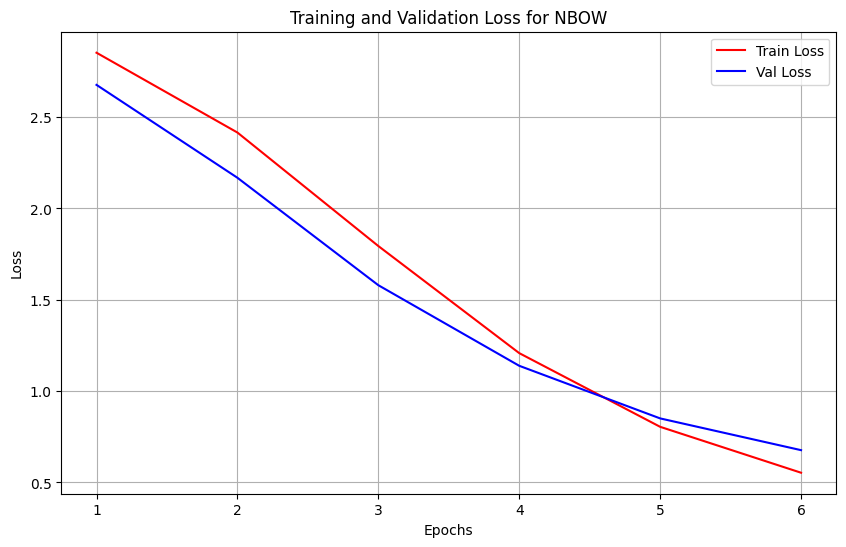

In [37]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits
plot_loss(train_loss_over_time_nbow, val_loss_over_time_nbow, 'NBOW')

### 3.6. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 84%
- 1 point for accuracy > 84% but <= 88%
- 2 points for accuracy > 88%

In [38]:
# load best model from checkpoint
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', map_location=device)

# evaluate model
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 24.04it/s]

Final Validation Accuracy: 0.8562334217506631
Final Validation F1-Score: 0.851117858612087


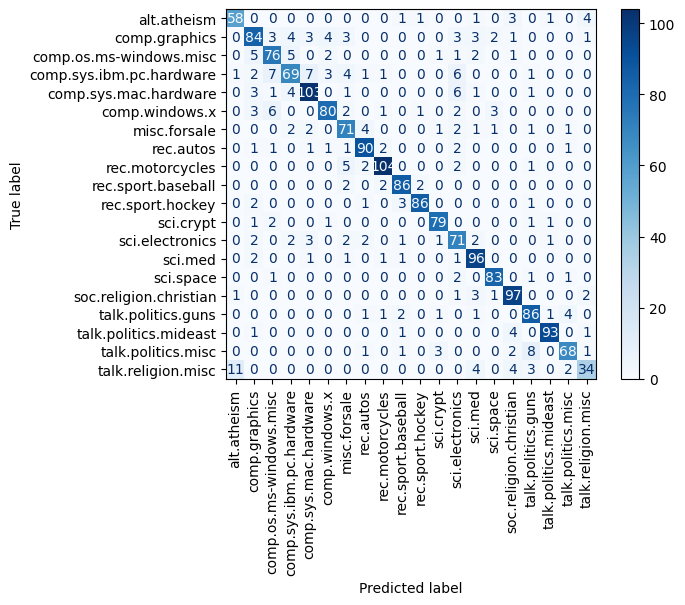

In [39]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 4. Simple Deep Averaging Networks (DAN) [5 points - Programming + 3 points - Non-programming]

Now, let's look at how to improve performance of the NBOW model. One such way without drastically changing the model complexity is DAN.

The core idea of a DAN is to simplify the process of understanding text by averaging the embeddings of words in a sentence or document. This creates a single vector representation that captures the overall meaning of the text.

In implementation, a DAN typically involves the following steps:

1. Convert each token into an embedding.
2. Average these embeddings to create a single vector that represents the entire document.
3. Pass this averaged vector through one hidden fully connected neural network layer.
4. Use ReLU activation
5. Use the output of these layers for tasks like classification.

This approach is simpler and often faster than more complex architectures like LSTMs or Transformers, while still providing robust performance for many tasks. However, it might not capture nuances in language as effectively as these more complex models.

*NOTE*: Use the same approach to handle pad_tokens as you used in NBOW.

### 4.1. Model Definition [3 points - Programming]

In the following cell, define the architecture of a DAN in the same way as you implemented NBOW-RAND in Section 2 with. Use the following image as a reference along with Section 3 and Figure 1 (right) of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf).

Refer to the following equation on how to define DAN -


$$ h_{avg} = \frac{1}{n} \sum_t emb(x_t) $$

$$ h_2 = (w_1h_{avg}) $$

$$ h'_{2} = max(0, h_2) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w_2^T h'_{2} + b) $$

where $w \in R^d$ is a parameter vector.

*Hint*: Make sure to handle the case where the input contains pad tokens. We don't want to consider them in our average.


In [40]:
# export
class DAN(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 4 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    # 3. A ReLU activation (see nn.ReLU)
    # 4. A linear layer (see nn.Linear)
    #
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=20):
        # vocab_size is the size of the vocabulary
        # embedding_dim is the dimension of the word embeddings
        # hidden_dim is the dimension of the hidden layer outputs, i.e., the 2nd module as per the definition above
        super().__init__()
        ## YOUR CODE STARTS HERE ##
        # 1) NO padding_idx here (test expects non-zero PAD row to survive)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 2) Hidden MLP: avg-emb -> ReLU -> logits
        self.proj1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu  = nn.ReLU()
        self.out   = nn.Linear(hidden_dim, num_classes)
        ## YOUR CODE ENDS HERE ##

    # helper method
    def _masked_average(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        """
        x:  (B, T) Long
        emb:(B, T, D) Float
        returns h_avg: (B, D)
        """
        mask = (x != PADDING_VALUE).unsqueeze(-1)            # (B, T, 1) bool
        emb_masked = emb * mask                              # zero-out PAD positions
        lengths = mask.sum(dim=1).clamp(min=1).to(emb.dtype) # (B, 1)
        h_avg = emb_masked.sum(dim=1) / lengths              # (B, D)
        return h_avg

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        # x: (B, T)
        emb  = self.embedding(x)                 # (B, T, D)  (PAD row stays as-is)
        havg = self._masked_average(x, emb)      # (B, D)     (PAD ignored here)
        h    = self.relu(self.proj1(havg))       # (B, H)
        logits = self.out(h)                     # (B, C)
        return logits

        ## YOUR CODE ENDS HERE ##

    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def get_hidden(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        emb  = self.embedding(x)                 # (B, T, D)
        havg = self._masked_average(x, emb)      # (B, D)
        h    = self.relu(self.proj1(havg))       # (B, H)
        return h
        ### YOUR CODE ENDS HERE ###

    def set_hidden_weight(self, weight, bias):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (embedding_dim, hidden_dim)
            bias: torch.tensor of shape (1, hidden_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.proj1.weight.copy_(weight)
            self.proj1.bias.copy_(bias.squeeze(0))
        ### YOUR CODE ENDS HERE ###


In [41]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def dan_test_local_embeddings():
    embedding_dim = 3
    vocab_size = 5
    model = DAN(embedding_dim=embedding_dim, vocab_size=vocab_size, hidden_dim=10)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")

def dan_test_local_hidden_layer():
    vocab_size = 5
    embedding_dim = 3
    hidden_dim = 3

    model = DAN(vocab_size, embedding_dim, hidden_dim)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_hidden_weight(torch.arange(9).reshape(embedding_dim, hidden_dim) / 50, torch.arange(3).reshape(1, hidden_dim) / 50)

    output = model.get_hidden(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_output = torch.tensor([[0.0099, 0.0573, 0.1046],
                                    [0.0092, 0.0544, 0.0996]])

    if torch.allclose(output, correct_output, atol=0.001):
        print("Passed local hidden layer test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_output}\nbut you got:\n{output}")

dan_test_local_embeddings()
dan_test_local_hidden_layer()

Passed local embedding test
Passed local hidden layer test


### 4.2. DAN Training [3 points - Non-programming]

In this section (and all later sections), you will leverage the same functions defined in Section 3 to train your DAN. To do this, simply initialize your DAN Model and pass that object to the training and evaluation loop to train your model.

Assign and tune the below hyperparameters to optimize your model

In [42]:
# export
def get_dan_model(vocab_size, embedding_dim, hidden_dim):
    """
    This function returns an instance of the DAN model. Initialize the DAN model here and return it. Note that the hidden_dim will be the dimension of the hidden layer in DAN.
    """
    model = None
    ## YOUR CODE STARTS HERE ##
    model = DAN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_classes=len(id2label)   # 20 for this dataset
    )
    ## YOUR CODE ENDS HERE ##
    return model

In [43]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_dan():
  ### your hyper parameters
    learning_rate = 2e-3           # good starting point for Adam
    epochs = 8                     # DAN usually converges in 6–10 epochs
    hidden_layer_dimensions = 256  # can try 128–512; 256 is balanced
    embedding_dim = 200            # 100–300 is common for word embeddings
    ###
    return learning_rate, epochs, hidden_layer_dimensions, embedding_dim


In [44]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, hidden_layer_dimensions, embedding_dim = get_hyperparams_dan()
dan_model = get_dan_model(len(train_vocab.keys()), embedding_dim, hidden_layer_dimensions).to(device)
criterion = get_criterion()
optimizer = get_optimizer(dan_model, learning_rate)
train_loss_over_time_dan = []
val_loss_over_time_dan = []
for epoch in range(epochs):
    train_loss = train_loop(dan_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(dan_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_dan.append(train_loss)
    val_loss_over_time_dan.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

save_checkpoint(dan_model, 'dan')

Evaluating Model: 100%|██████████| 15/15 [00:01<00:00, 14.55it/s]


Epoch 1 -- Train_Loss: 2.631095888250965 -- Val_Loss: 2.1322281837463377 -- Val_Accuracy: 0.3458885941644562 -- Val_F1: 0.29544787152014723


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 27.18it/s]


Epoch 2 -- Train_Loss: 1.535145201925504 -- Val_Loss: 1.1974853237469991 -- Val_Accuracy: 0.6350132625994694 -- Val_F1: 0.6203358039812354


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s]


Epoch 3 -- Train_Loss: 0.7725956200037972 -- Val_Loss: 0.7459546566009522 -- Val_Accuracy: 0.7814323607427056 -- Val_F1: 0.7781813203873109


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 22.09it/s]


Epoch 4 -- Train_Loss: 0.3977512454582473 -- Val_Loss: 0.571980877717336 -- Val_Accuracy: 0.8318302387267904 -- Val_F1: 0.8296252601825647


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 27.48it/s]


Epoch 5 -- Train_Loss: 0.2135626933205936 -- Val_Loss: 0.5009664555390676 -- Val_Accuracy: 0.8583554376657825 -- Val_F1: 0.8576056069324265


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 24.22it/s]


Epoch 6 -- Train_Loss: 0.12055843140361673 -- Val_Loss: 0.45328702131907145 -- Val_Accuracy: 0.8647214854111406 -- Val_F1: 0.8627985838704586


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 27.82it/s]


Epoch 7 -- Train_Loss: 0.06808512058045904 -- Val_Loss: 0.45672651529312136 -- Val_Accuracy: 0.8652519893899204 -- Val_F1: 0.8643792826078727


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 22.97it/s]


Epoch 8 -- Train_Loss: 0.03859390621468172 -- Val_Loss: 0.4390819211800893 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.8699418610522972
Checkpoint saved to /content/drive/MyDrive/HW2/model_weights/checkpoint_dan_ce.pt


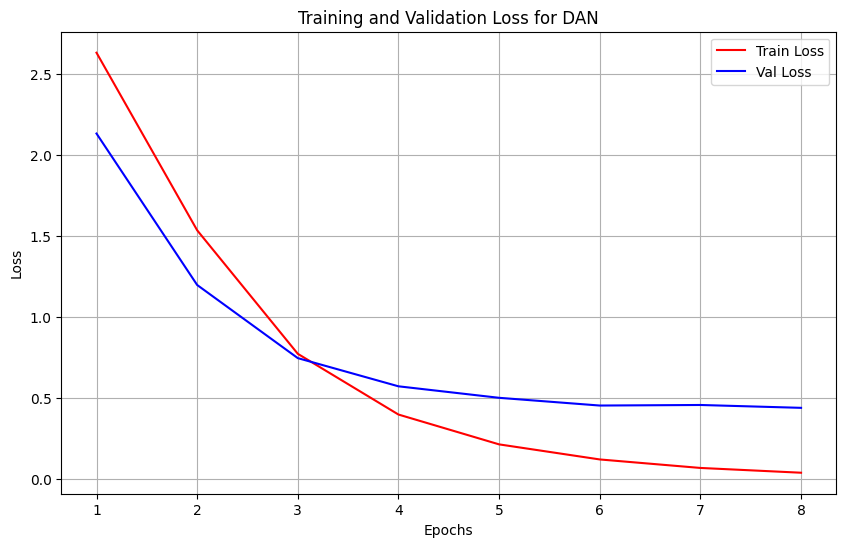

In [45]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF to get credits
plot_loss(train_loss_over_time_dan, val_loss_over_time_dan, 'DAN')

### 4.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 84%
- 1 point for accuracy > 84% but <= 88%
- 2 points for accuracy > 88%

In [46]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, hidden_layer_dimensions, embedding_dim = get_hyperparams_dan()
dan_model = get_dan_model(len(train_vocab.keys()), embedding_dim, hidden_layer_dimensions).to(device)
load_checkpoint(dan_model, 'dan', map_location=device)

true, pred, val_loss = val_loop(dan_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 21.06it/s]

Final Validation Accuracy: 0.8721485411140584
Final Validation F1-Score: 0.8699418610522972


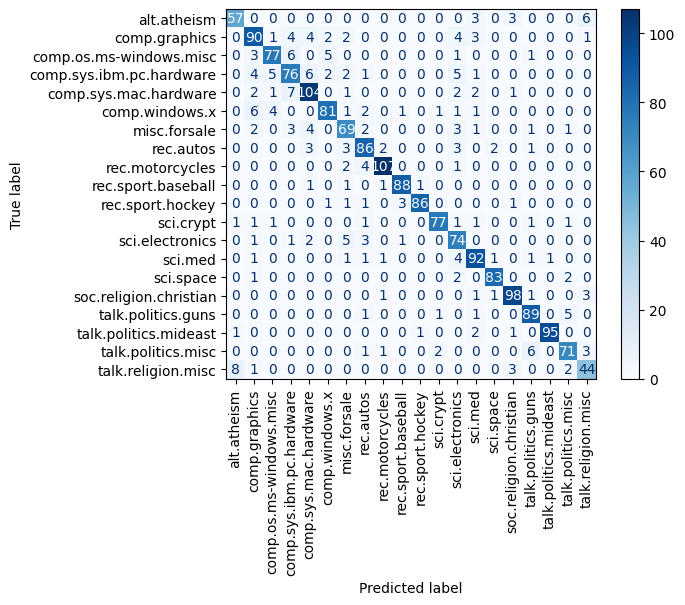

In [47]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 5. Attention-based Models [21 points - Programming + 9 points - Non-programming]
 In the simplest terms, attention allows a network to differentially focus on specific input words rather considering their importance equally, as done in the previous sections by averaging. For example, often times the mere presence of word "election" is enough to ascertain the category of the sentence to be politics.

 There are various types of attention which we will dsicuss in much more depth throughout course. This section is just to provide a conceptual flavor of attention as a concept. In the below parts, you will work with three different simple types of attention.

### 5.1. Attention-weighted NBOW [7 points - Programming + 3 points - Non-programming]



You will now define an encoder that uses a simple attention function to produce a weight for each word in the sentence followed by a sum of the attention-weighted word embeddings. Simple attention allows the model to learn a weight vector $\alpha_t$ which represents how important will different tokens in a document be.

Consider $u$ to be a single attention head (a learnable PyTorch parameter). With this,

$$ \alpha_t \varpropto \exp\{cos(u,emb(x_t))\} $$

*Note*: This needs to be normalized.

$$ h_{att} = \sum_t \alpha_t emb(x_t) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T h_{att}) $$

where $w \in R^d$ is a parameter vector.

In this model, the unnormalized attention weight for a word $x$ is computed using the cosine similarity between a learnable parameter $u$ and the word embedding for $x$ followed by exponentiation. To get normalized weights $\alpha_t$, normalize across all words in the sentence. Then multiply the attention weights by the word embeddings and sum the attention-weighted embeddings.

*HINT*: See if Softmax function can help with this

*Hint*: Make sure to handle the case where the input contains pad tokens.

#### 5.1.1. Model Definition [5 points - Programming]

Define your simple attention model below.

In [48]:
#export

class SimpleAttentionNBOW(nn.Module):
    """
    This class implements the Attention-weighted Neural Bag of Words model.
    """

    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super().__init__()
        # Do NOT set padding_idx here
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # learnable attention vector u (size d)
        self.att_vector = nn.Parameter(torch.randn(embedding_dim))

        # classifier on top of attention-weighted average
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        emb = self.embedding(x)                     # (B, T, d)
        alphas = self.get_attention_matrix(x)       # (B, T)
        h_att = torch.einsum("bt,btd->bd", alphas, emb)   # (B, d)
        logits = self.fc(h_att)                     # (B, C)
        return logits
        ## YOUR CODE ENDS HERE ##

        # return predictions

    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def set_attention_weights(self, weight):
        '''
        This function sets the attention weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.att_vector.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        '''
        ### YOUR CODE STARTS HERE ###
        emb = self.embedding(x)                     # (B, T, d)
        # cosine similarity between u and each token embedding
        u = F.normalize(self.att_vector, dim=0)     # (d,)
        e = F.normalize(emb, dim=-1) @ u            # (B, T)

        # mask out pad positions (token id == 0)
        mask = (x != 0)                              # (B, T) bool
        e_masked = e.masked_fill(~mask, float('-inf'))

        # normalized attention weights (pad positions -> 0)
        alphas = F.softmax(e_masked, dim=1)
        alphas = alphas * mask.float()
        # (optional) renormalize to ensure sum to 1 over non-pad tokens
        denom = alphas.sum(dim=1, keepdim=True).clamp_min(1e-9)
        alphas = alphas / denom
        return alphas
        ### YOUR CODE ENDS HERE ###


In [49]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def simple_attention_nbow_test_local_embeddings():
    model = SimpleAttentionNBOW(embedding_dim=3, vocab_size=5)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def simple_attention_nbow_test_local_attn():
    model = SimpleAttentionNBOW(embedding_dim=3, vocab_size=5)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_attention_weights(torch.tensor([0.1, 0.2, 0.3]))
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[0.2033, 0.1995, 0.1975, 0.1964, 0.2033],
                                              [0.3387, 0.3323, 0.3290, 0.0000, 0.0000]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")

simple_attention_nbow_test_local_embeddings()
simple_attention_nbow_test_local_attn()

Passed local embedding test
Passed local Attn test


#### 5.1.2. Model Training [3 points - Non-Programming]
Assign and tune the below hyperparameters to optimize your model

In [50]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_simple_attention():
  ### your hyper parameters
    learning_rate = 3e-3
    epochs = 6
    embedding_dim = 200
    return learning_rate, epochs, embedding_dim

In [51]:
# export
def get_simple_attention_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the SimpleAttentionNBOW model. Initialize the SimpleAttentionNBOW model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##
    model = SimpleAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    ## YOUR CODE ENDS HERE ##
    return model

In [52]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_simple_attention()
simple_attention_model = get_simple_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim).to(device)
criterion = get_criterion()
train_loss_over_time_sa = []
val_loss_over_time_sa = []
optimizer = get_optimizer(simple_attention_model, learning_rate)
for epoch in range(epochs):
    train_loss = train_loop(simple_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(simple_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_sa.append(train_loss)
    val_loss_over_time_sa.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(simple_attention_model, 'simple_attention')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 17.58it/s]


Epoch 1 -- Train_Loss: 2.736393112247273 -- Val_Loss: 2.417440923055013 -- Val_Accuracy: 0.3957559681697613 -- Val_F1: 0.37015600140469024


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


Epoch 2 -- Train_Loss: 1.8880917248079332 -- Val_Loss: 1.4348665873209636 -- Val_Accuracy: 0.7076923076923077 -- Val_F1: 0.6884907918440354


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


Epoch 3 -- Train_Loss: 0.9492138997983124 -- Val_Loss: 0.8037997364997864 -- Val_Accuracy: 0.8376657824933686 -- Val_F1: 0.8318246844272188


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 21.65it/s]


Epoch 4 -- Train_Loss: 0.4750620311094543 -- Val_Loss: 0.5375499268372853 -- Val_Accuracy: 0.8811671087533156 -- Val_F1: 0.8755857063606379


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 17.42it/s]


Epoch 5 -- Train_Loss: 0.2701356160943791 -- Val_Loss: 0.42807154059410096 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8920795319397552


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 21.15it/s]


Epoch 6 -- Train_Loss: 0.1675403071409565 -- Val_Loss: 0.3675137182076772 -- Val_Accuracy: 0.9039787798408488 -- Val_F1: 0.9001916573256992
Checkpoint saved to /content/drive/MyDrive/HW2/model_weights/checkpoint_simple_attention_ce.pt


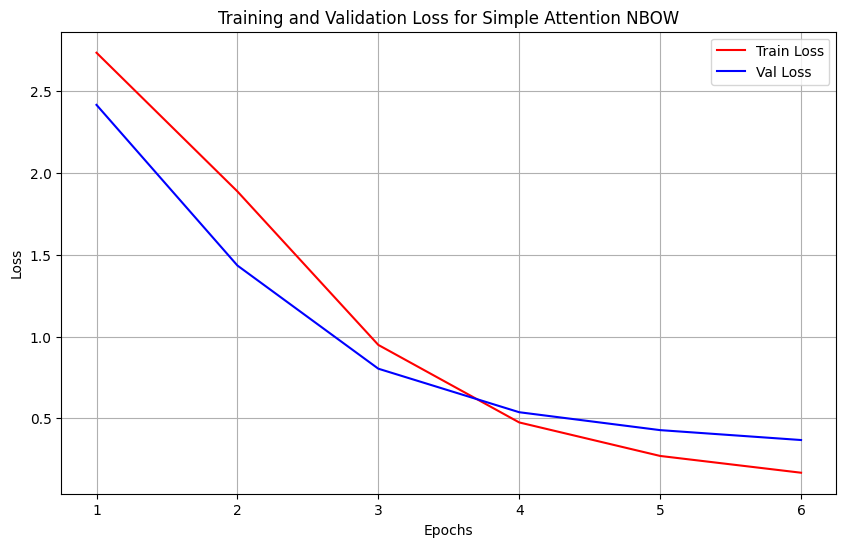

In [53]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF to get credits
plot_loss(train_loss_over_time_sa, val_loss_over_time_sa, 'Simple Attention NBOW')

#### 5.1.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [54]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_simple_attention()
simple_attention_model = get_simple_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim).to(device)
load_checkpoint(simple_attention_model, 'simple_attention', map_location=device)

true, pred, val_loss = val_loop(simple_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 15.44it/s]

Final Validation Accuracy: 0.9039787798408488
Final Validation F1-Score: 0.9001916573256992


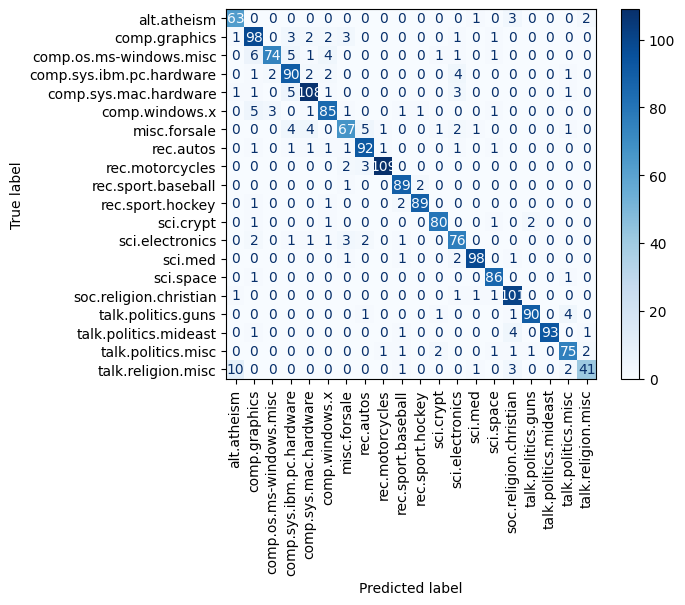

In [55]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 5.2. MultiHead Attention NBOW [7 points - Programming + 3 points - Non-programming]

The prior model only uses a single attention function. In this section, you will implement a multi-head attention model. You will use $k$ attention heads, each with its own parameters $u_i \in R^d$ ($\forall i \in [1..k]$) and a single large vector before the classification to weight them all together $w \in R^{d \cdot k}$.

$$ \alpha_{t,i} \varpropto \exp\{cos(u_i,emb(x_t))\} $$

$$ h_{att}(i) = \sum_t\alpha_{t,i} emb(x_t) $$

With the probability of a task instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T [h_{att}(1), h_{att}(2), ..., h_{att}(k)]) $$

where [a,b] is the concatenation of vectors $a$ and $b$, into a single taller vector.

#### 5.2.1. Model Definition [5 points - Programming]

Define your Multi-head attention below

In [56]:
#export

class MultiHeadAttentionNBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_classes=20):
        ## YOUR CODE STARTS HERE ##
        super(MultiHeadAttentionNBOW, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        # (assumes PADDING_VALUE is defined globally; value 0 in your notebook)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PADDING_VALUE)

        # Learnable head vectors u_h (num_heads, embedding_dim)
        self.attn_heads = nn.Parameter(torch.randn(num_heads, embedding_dim))

        # Classifier over an aggregated (B, D) sentence vector
        self.fc = nn.Linear(embedding_dim * num_heads, num_classes, bias=False)
        ## YOUR CODE ENDS HERE ##

    # helper
    def _masked_softmax_over_time(self, scores, mask):
        """
        scores: (B, L, H)
        mask:   (B, L) with True for valid tokens
        returns softmax over L with mask -> (B, L, H)
        """
        # Put -inf where masked so they get zero prob after softmax
        scores = scores.masked_fill(~mask.unsqueeze(-1), float("-inf"))
        return torch.softmax(scores, dim=1)

    # helper
    def _attention_weights(self, x, emb=None):
        """
        x:   (B, L)
        emb: (B, L, D) optional (saves a re-embed)
        returns attn: (B, L, H)
        """
        if emb is None:
            emb = self.embedding(x)                       # (B, L, D)

        # Cosine similarity: normalize both sides
        emb_n = F.normalize(emb, p=2, dim=-1)             # (B, L, D)
        heads_n = F.normalize(self.attn_heads, p=2, dim=-1)  # (H, D)

        # scores_{b,l,h} = <emb_{b,l,:}, head_{h,:}>
        scores = torch.einsum("bld,hd->blh", emb_n, heads_n)  # (B, L, H)

        mask = (x != PADDING_VALUE)                       # (B, L)
        attn = self._masked_softmax_over_time(scores, mask)   # (B, L, H)
        # zero-out any residual numerics on padded positions
        attn = attn * mask.unsqueeze(-1)
        return attn

    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        # (B, L, D)
        emb = self.embedding(x)

        # (B, L, H) – uses self.attn_heads and masking correctly
        attn = self._attention_weights(x, emb)

        # context per head: (B, H, D)
        ctx = torch.einsum('blh,bld->bhd', attn, emb)

        # CONCATENATE heads (not average): (B, H*D)
        sent_vec = ctx.reshape(ctx.size(0), -1)

        # classifier has no bias; weight = 0.3 in the sanity test
        logits = self.fc(sent_vec)  # (B, num_classes)
        return logits
        ## YOUR CODE ENDS HERE ##


    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def set_attention_weights(self, weight):
        '''
        This function sets the attention weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (num_heads, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        if weight.shape != self.attn_heads.shape:
            raise ValueError(f"Expected weight shape {self.attn_heads.shape}, got {weight.shape}")
        with torch.no_grad():
            self.attn_heads.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch, num_heads))
        '''
        ### YOUR CODE STARTS HERE ###
        emb = self.embedding(x)                            # (B, L, D)
        return self._attention_weights(x, emb)             # (B, L, H)
        ### YOUR CODE ENDS HERE ###

In [57]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def multihead_attn_nbow_test_local():
    embedding_dim = 10
    vocab_size = 10
    num_heads = 3
    model = MultiHeadAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim, num_heads=num_heads)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.3)
    input = torch.tensor([[1,2,3,4,0,0,0],
                          [5,6,7,0,0,0,0]]) % vocab_size
    expected_result = torch.tensor(
        [[2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000],
        [2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

# local test for sanity:
def multi_attention_nbow_test_local_embeddings():
    model = MultiHeadAttentionNBOW(embedding_dim=3, vocab_size=5, num_heads=4)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def multi_attention_nbow_test_local_attn():
    model = MultiHeadAttentionNBOW(embedding_dim=3, vocab_size=5, num_heads=4)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_attention_weights(torch.tensor([[0.1, 0.2, 0.3],[0.1, 0.2, 0.3],[0.2, 0.2, 0.2],[0, 0.3, 0.3]]))
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[[0.2033, 0.2033, 0.1981, 0.2052],
                                                [0.1995, 0.1995, 0.2007, 0.1990],
                                                [0.1975, 0.1975, 0.2014, 0.1961],
                                                [0.1964, 0.1964, 0.2017, 0.1945],
                                                [0.2033, 0.2033, 0.1981, 0.2052]],

                                                [[0.3387, 0.3387, 0.3300, 0.3419],
                                                [0.3323, 0.3323, 0.3344, 0.3314],
                                                [0.3290, 0.3290, 0.3356, 0.3267],
                                                [0.0000, 0.0000, 0.0000, 0.0000],
                                                [0.0000, 0.0000, 0.0000, 0.0000]]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")

multi_attention_nbow_test_local_embeddings()
multi_attention_nbow_test_local_attn()
multihead_attn_nbow_test_local()

Passed local embedding test
Passed local Attn test
Passed local check


#### 5.2.2. Model Training [3 points - Non-Programming]

Assign and tune the below hyperparameters to optimize your model

In [58]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_multihead():
    learning_rate = 2e-3
    epochs = 8
    num_heads = 4
    embedding_dim = 128
    return learning_rate, epochs, num_heads, embedding_dim

In [59]:
#export
def get_multihead_attention_model(vocab_size, embedding_dim, num_heads):
    """
    This function returns an instance of the MultiHeadAttentionNBOW model. Initialize the MultiHeadAttentionNBOW model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##
    model = MultiHeadAttentionNBOW(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        num_heads=num_heads
    )
    ## YOUR CODE ENDS HERE ##
    return model

In [60]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, num_heads, embedding_dim = get_hyperparams_multihead()
multihead_attention_model = get_multihead_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim, num_heads=num_heads).to(device)
criterion = get_criterion()
optimizer = get_optimizer(multihead_attention_model, learning_rate)
train_loss_over_time_ma = []
val_loss_over_time_ma = []
for epoch in range(epochs):
    train_loss = train_loop(multihead_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(multihead_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_ma.append(train_loss)
    val_loss_over_time_ma.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(multihead_attention_model, 'multihead_attention')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 25.20it/s]


Epoch 1 -- Train_Loss: 2.6941782518968744 -- Val_Loss: 2.3544623057047525 -- Val_Accuracy: 0.34907161803713527 -- Val_F1: 0.3140543633453659


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 24.60it/s]


Epoch 2 -- Train_Loss: 1.9156382639529341 -- Val_Loss: 1.56910400390625 -- Val_Accuracy: 0.6228116710875331 -- Val_F1: 0.60396973252852


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 26.05it/s]


Epoch 3 -- Train_Loss: 1.1397247506400285 -- Val_Loss: 1.0092854261398316 -- Val_Accuracy: 0.7607427055702918 -- Val_F1: 0.7495446419308451


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 19.38it/s]


Epoch 4 -- Train_Loss: 0.665594593448154 -- Val_Loss: 0.7128823399543762 -- Val_Accuracy: 0.8259946949602122 -- Val_F1: 0.8209190672501212


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 25.59it/s]


Epoch 5 -- Train_Loss: 0.41062481272018564 -- Val_Loss: 0.5629419287045797 -- Val_Accuracy: 0.8541114058355438 -- Val_F1: 0.8499588168188703


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 26.61it/s]


Epoch 6 -- Train_Loss: 0.26868515802642046 -- Val_Loss: 0.46803450187047324 -- Val_Accuracy: 0.8705570291777188 -- Val_F1: 0.8667949919990239


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 26.01it/s]


Epoch 7 -- Train_Loss: 0.18259837049043784 -- Val_Loss: 0.4146982649962107 -- Val_Accuracy: 0.8875331564986737 -- Val_F1: 0.8834335634053201


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 26.98it/s]


Epoch 8 -- Train_Loss: 0.12656540512028386 -- Val_Loss: 0.37954349915186564 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8918898620486037
Checkpoint saved to /content/drive/MyDrive/HW2/model_weights/checkpoint_multihead_attention_ce.pt


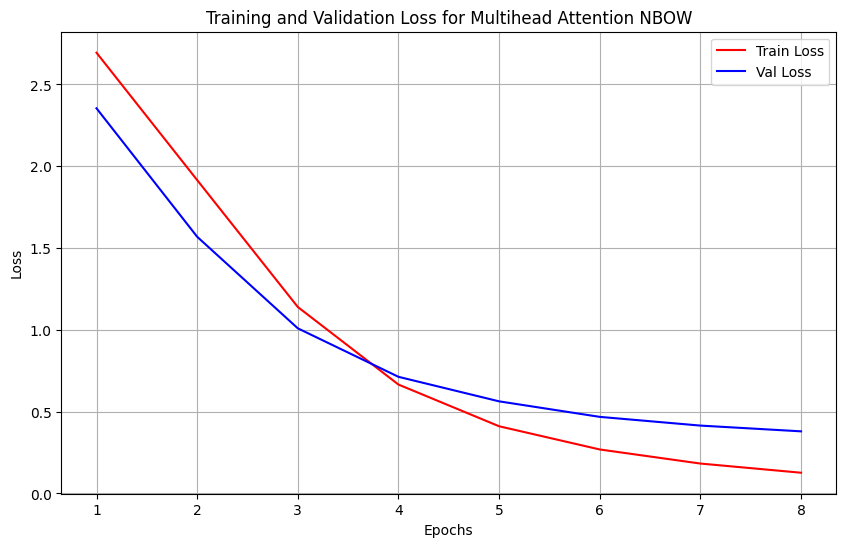

In [61]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits
plot_loss(train_loss_over_time_ma, val_loss_over_time_ma, 'Multihead Attention NBOW')

#### 5.2.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [62]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, num_heads, embedding_dim = get_hyperparams_multihead()
multihead_attention_model = get_multihead_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim, num_heads=num_heads).to(device)
load_checkpoint(multihead_attention_model, 'multihead_attention')

true, pred, val_loss = val_loop(multihead_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 26.87it/s]

Final Validation Accuracy: 0.8960212201591512
Final Validation F1-Score: 0.8918898620486037


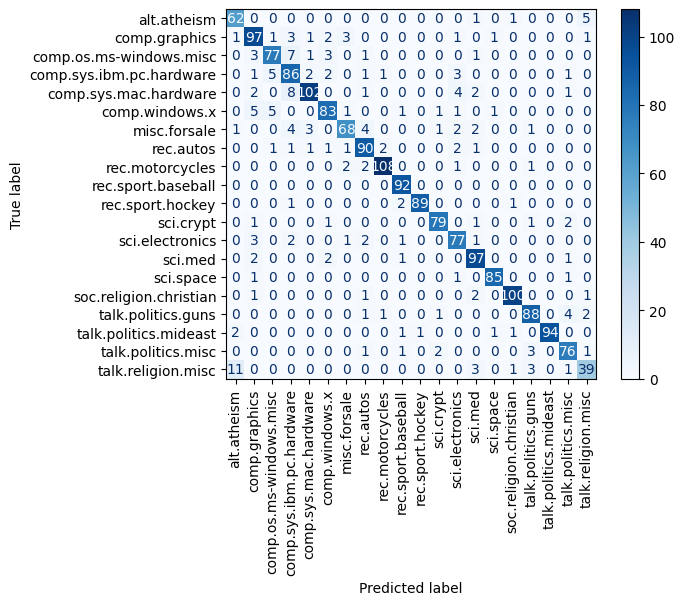

In [63]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 5.3. Self-Attention NBOW [7 points - Programming + 3 points - Non-programming]

Self-attention is a mechanism in neural networks that enables each element in a sequence to consider and weigh the importance of every other element. This facilitates a more nuanced and context-aware representation of the sequence, greatly enhancing the capabilities of models in tasks involving sequential data, particularly in NLP. It has gained prominence with the introduction and success of Transformer models, like BERT, GPT (including GPT-3), and others. This is not a full-fledged implementation of it, but instead a conceptual flavor of the mechanism.

We will now define an encoder that uses a simple form of self-attention when producing attention weights for each word in the sentence:
$$a_{ts} = emb(x_t)^Temb(x_s)$$
$$α_t \propto exp(\sum_s a_{ts})$$
$$h_{self} = \sum α_temb(x_t)$$
Then, the probability of a class is given by
$$softmax(w^Th_{self})$$
The unnormalized attention weight for a word $x$ is computed using the dot product between its embedding and those for all other words in the sentence, followed by a summation and exponentiation. Unlike the model in Section 5.1., this model does not introduce any new parameters for computing the attention function, simply using the same word embeddings for the attention. Therefore, this model has the same number of parameters as the model in Section 2.
For improved stability, we can also add a “residual connection”, which would change Eq. 1 to
$$softmax(w^T(h_{self} + h_{avg}))$$
where $h_{avg}$ is computed as in Section 2 (though using the same word embeddings as in $h_{self}$).


#### 5.3.1. Model Definition [5 points - Programming]
Define your self attention model below

In [68]:
#export
class SelfAttentionNBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super(SelfAttentionNBOW, self).__init__()
        # YOUR CODE STARTS HERE
        # embeddings with padding index
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PADDING_VALUE)
        # linear classifier over the sentence vector
        self.fc = nn.Linear(embedding_dim, num_classes, bias=False)
        # YOUR CODE ENDS HERE

    def forward(self, x):
        # YOUR CODE STARTS HERE
        emb  = self.embedding(x)                 # (B, L, D)
        mask = (x != PADDING_VALUE)              # (B, L)  True for valid tokens

        # pairwise dot-products (no scaling; matches the assignment spec)
        scores = torch.bmm(emb, emb.transpose(1, 2))          # (B, L, L)

        # zero out contributions from padded "keys" before summing over s
        scores_for_sum = scores.masked_fill(~mask.unsqueeze(1), 0.0)  # (B, L, L)

        # logits for alpha: sum over s, then kill padded "queries"
        alpha_logits = scores_for_sum.sum(dim=2)                        # (B, L)
        alpha_logits = alpha_logits.masked_fill(~mask, float('-inf'))   # (B, L)

        # normalized attention over tokens t
        alpha = torch.softmax(alpha_logits, dim=1)                      # (B, L)

        # sentence vector
        h_self = (alpha.unsqueeze(-1) * emb).sum(dim=1)                 # (B, D)

        lengths = mask.sum(dim=1).clamp_min(1).unsqueeze(-1)            # (B, 1)
        h_avg = (emb * mask.unsqueeze(-1)).sum(dim=1) / lengths         # (B, D)

        # classification logits
        h = h_self + h_avg
        logits = self.fc(h)                                             # (B, C)
        return logits
        # YOUR CODE ENDS HERE
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight.copy_(weight)
        ### YOUR CODE ENDS HERE ###
    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch)
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch, max seq length in batch)
        '''
        ### YOUR CODE STARTS HERE ###
        emb  = self.embedding(x)                 # (B, L, D)
        mask = (x != PADDING_VALUE)              # (B, L)

        scores = torch.bmm(emb, emb.transpose(1, 2))                # (B, L, L)
        scores_for_sum = scores.masked_fill(~mask.unsqueeze(1), 0.) # zero padded keys

        alpha_logits = scores_for_sum.sum(dim=2)                    # (B, L)
        alpha_logits = alpha_logits.masked_fill(~mask, float('-inf'))
        alpha = torch.softmax(alpha_logits, dim=1)                  # (B, L)

        # zero-out pads for readability in tests
        return alpha * mask
        ### YOUR CODE ENDS HERE ###


In [69]:
# local test for sanity:
def self_attention_nbow_test_local():
    model = SelfAttentionNBOW(vocab_size=10, embedding_dim=10)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.3)
    input = torch.tensor([[1,2,3,4,0,0,0],
                          [5,6,7,0,0,0,0]]) % 10

    expected_result = torch.tensor(
        [[1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000],
        [1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

def self_attention_nbow_test_local_embeddings():
    model = SelfAttentionNBOW(vocab_size=5, embedding_dim=3)
    model.set_embedding_weight(torch.arange(15).reshape(5, 3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1, 2, 3, 4, 1], [1, 2, 3, 0, 0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")

def self_attention_nbow_test_local_attn():
    model = SelfAttentionNBOW(vocab_size=5, embedding_dim=3)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[0.1675, 0.1921, 0.2203, 0.2526, 0.1675],
        [0.3085, 0.3327, 0.3588, 0.0000, 0.0000]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")
self_attention_nbow_test_local()
self_attention_nbow_test_local_embeddings()
self_attention_nbow_test_local_attn()


Passed local check
Passed local embedding test
Passed local Attn test


In [70]:
#export
def get_self_attention_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the Self Attention model. Initialize the Self Attention model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##
    model = SelfAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    ## YOUR CODE ENDS HERE ##
    return model

#### 5.3.2. Model Training [3 points - Non-Programming]
Assign and tune the below hyperparameters to optimize your model

In [71]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_self_attn():
    learning_rate = 2e-4
    epochs = 10
    embedding_dim = 200
    return learning_rate, epochs, embedding_dim

In [73]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_self_attn()
self_attention_model = get_self_attention_model(len(train_vocab.keys()),embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(self_attention_model, learning_rate)
train_loss_over_time_sea = []
val_loss_over_time_sea = []
for epoch in range(epochs):
    train_loss = train_loop(self_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(self_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_sea.append(train_loss)
    val_loss_over_time_sea.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(self_attention_model, 'self_attention')

Evaluating Model: 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]


Epoch 1 -- Train_Loss: 3.004465070821471 -- Val_Loss: 2.9674195448557534 -- Val_Accuracy: 0.0870026525198939 -- Val_F1: 0.03406270740447932


Evaluating Model: 100%|██████████| 15/15 [00:01<00:00, 11.15it/s]


Epoch 2 -- Train_Loss: 2.958218402781729 -- Val_Loss: 2.9533480167388917 -- Val_Accuracy: 0.1129973474801061 -- Val_F1: 0.056907379784591164


Evaluating Model: 100%|██████████| 15/15 [00:01<00:00, 10.86it/s]


Epoch 3 -- Train_Loss: 2.9440537711321295 -- Val_Loss: 2.944888130823771 -- Val_Accuracy: 0.08647214854111406 -- Val_F1: 0.038486176732916384


Evaluating Model: 100%|██████████| 15/15 [00:01<00:00, 10.46it/s]


Epoch 4 -- Train_Loss: 2.932593761864355 -- Val_Loss: 2.930649407704671 -- Val_Accuracy: 0.13527851458885942 -- Val_F1: 0.07229469600101009


Evaluating Model: 100%|██████████| 15/15 [00:02<00:00,  7.46it/s]


Epoch 5 -- Train_Loss: 2.920119386608318 -- Val_Loss: 2.9229045073191324 -- Val_Accuracy: 0.129973474801061 -- Val_F1: 0.06769159410544288


Evaluating Model: 100%|██████████| 15/15 [00:01<00:00, 11.11it/s]


Epoch 6 -- Train_Loss: 2.9090457972833668 -- Val_Loss: 2.9136950174967446 -- Val_Accuracy: 0.16127320954907162 -- Val_F1: 0.12507654677210095


Evaluating Model: 100%|██████████| 15/15 [00:01<00:00, 11.03it/s]


Epoch 7 -- Train_Loss: 2.8977565927020574 -- Val_Loss: 2.9020198980967202 -- Val_Accuracy: 0.1883289124668435 -- Val_F1: 0.14458990076206119


Evaluating Model: 100%|██████████| 15/15 [00:01<00:00, 10.42it/s]


Epoch 8 -- Train_Loss: 2.8868542081218656 -- Val_Loss: 2.8906323115030923 -- Val_Accuracy: 0.17771883289124668 -- Val_F1: 0.1356919960585522


Evaluating Model: 100%|██████████| 15/15 [00:01<00:00,  8.10it/s]


Epoch 9 -- Train_Loss: 2.8748864157725187 -- Val_Loss: 2.8835681597391765 -- Val_Accuracy: 0.16445623342175067 -- Val_F1: 0.11958036988148299


Evaluating Model: 100%|██████████| 15/15 [00:01<00:00, 11.13it/s]


Epoch 10 -- Train_Loss: 2.863283878665859 -- Val_Loss: 2.875253756841024 -- Val_Accuracy: 0.19310344827586207 -- Val_F1: 0.14849821081410888
Checkpoint saved to /content/drive/MyDrive/HW2/model_weights/checkpoint_self_attention_ce.pt


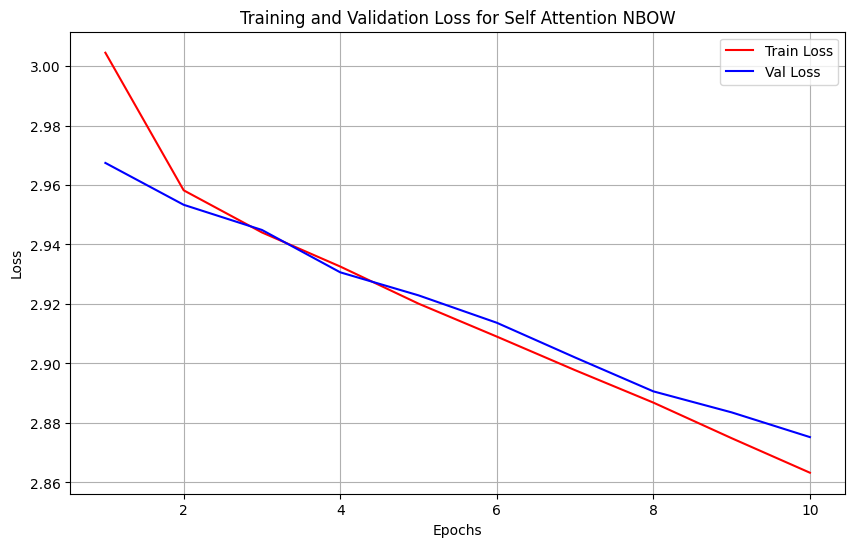

In [74]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits
plot_loss(train_loss_over_time_sea, val_loss_over_time_sea, 'Self Attention NBOW')

#### 5.3.3. Model Evaluation Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [75]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_self_attn()
self_attention_model = get_self_attention_model(len(train_vocab.keys()),embedding_dim).to(device)
load_checkpoint(self_attention_model, 'self_attention', map_location=device)

true, pred, val_loss = val_loop(self_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]

Final Validation Accuracy: 0.19310344827586207
Final Validation F1-Score: 0.14849821081410888


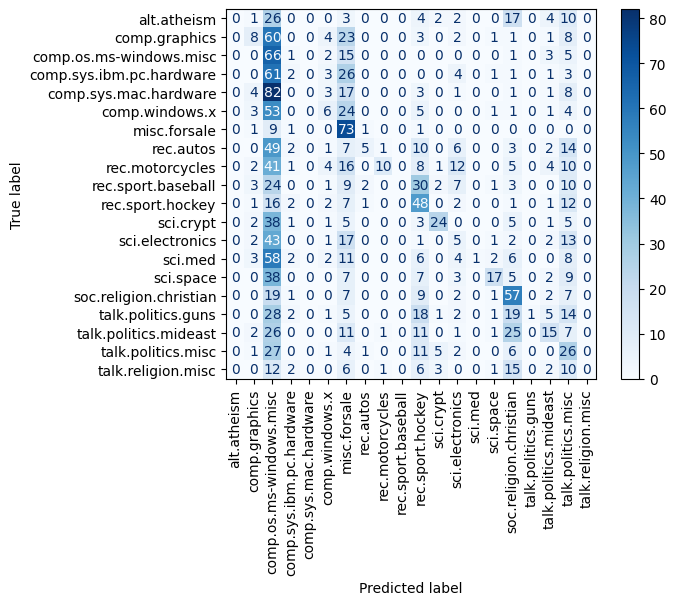

In [76]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 6. Perceptron and Hinge Losses (16 Points - Programming)



### 6.1. Perceptron Loss (5 points - Programming)

The perceptron loss penalizes the model only when the true class is not the most confident prediction. If the model incorrectly assigns a higher score to another class, the perceptron loss encourages the model to adjust its weights to fix this mistake.

This is achieved by considering the difference between the maximum score among all other classes and the score of the true class. If the maximum incorrect score is higher than the true class score, the model receives a penalty proportional to how much worse the true class was predicted compared to the highest incorrect class.

Given a set of predictions from the perceptron model for a batch of samples, we denote:

- $ \mathbf{y} \in \mathbb{R}^{B \times C} $: The matrix of predicted scores, where $B$ is the batch size and $C$ is the number of classes. Each row represents the predicted scores for one sample.
- $\mathbf{y}_{\text{true}} \in \{0, 1, \ldots, C-1\}^{B}$: The ground truth labels, where each entry is an integer representing the correct class label for each sample.

For a given sample \( i \), let:

- $s_j $ be the score for class $j$ (from the predicted score vector).
- $ s_{\text{true}} $ be the score for the true class.

The **perceptron loss** for data instance $x_i$ is defined as:

$$
L_{\text{perceptron}}(i) = \max \left( 0, \max_{j} (s_j) - s_{\text{true}} \right)
$$

For batches, we compute the loss for each sample and take the mean over the batch

Implement this PerceptronLoss in the forward method below.

NOTE: The scores are logits, the predictions of models before doing any softmax.


In [77]:
# export

class PerceptronLoss(nn.Module):
    def __init__(self):
        super(PerceptronLoss, self).__init__()

    def forward(self, predictions, labels):
        """
        Calculate the perceptron loss between predictions and labels.

        Args:
            predictions (torch.Tensor): The predictions from the model for a batch of inputs.
                                        Shape should be (batch_size, num_classes).
            labels (torch.Tensor): The ground truth labels for each input in the batch.
                                   Shape should be (batch_size,) with each value between 0 and num_classes-1.

        Returns:
            scalar: The mean perceptron loss for the batch.
        """
        loss = None
        # YOUR CODE STARTS HERE
        # Get the score for the true class
        true_scores = predictions[torch.arange(predictions.size(0)), labels]  # shape: (batch_size,)

        # Get the maximum score among *all* classes for each sample
        max_scores, _ = torch.max(predictions, dim=1)  # shape: (batch_size,)

        # Perceptron loss per sample: max(0, max_j(s_j) - s_true)
        losses = torch.clamp(max_scores - true_scores, min=0)

        # Take mean across the batch
        loss = losses.mean()
        # YOUR CODE ENDS HERE
        return loss

In [78]:
# DO NOT CHANGE THIS CELL
perceptron_loss = PerceptronLoss()

def test_correct_classification():
    predictions = torch.tensor([[3.0, 2.0, 1.0],
                                [1.0, 4.0, 2.0]])
    labels = torch.tensor([0, 1])
    loss = perceptron_loss(predictions, labels).item()
    expected_loss = 0.0
    rtol = 0.001  # Relative tolerance
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case passed for correct classification')
    else:
        print(f"Test case failed for correct classification, expected value was\n{expected_loss}\nbut you got:\n{loss}")

# Test for incorrect classification
def test_incorrect_classification():
    predictions = torch.tensor([[1.0, 3.0, 2.0],
                                [1.0, 2.0, 4.0]])
    labels = torch.tensor([0, 1])

    expected_loss = 2.0
    loss = perceptron_loss(predictions, labels).item()

    rtol = 0.001  # Relative tolerance
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case passed for incorrect classification')
    else:
        print(f"Test case failed for incorrect classification, expected value was\n{expected_loss}\nbut you got:\n{loss}")

# Execute test cases
test_correct_classification()
test_incorrect_classification()

Test case passed for correct classification
Test case passed for incorrect classification


### 6.2. NBOW Training using Perceptron Loss (3 points - Programming)

Credits will be awarded as per the following final results on the Gradescope split -
- 0 points for accuracy <= 75%
- 1 point for accuracy > 75% but <= 80%
- 2 points for accuracy > 80%

In [79]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = PerceptronLoss()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_perceptron = []
val_loss_over_time_perceptron = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_perceptron.append(train_loss)
    val_loss_over_time_perceptron.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

save_checkpoint(nbow_model, 'nbow', loss_fn='perceptron')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 28.96it/s]


Epoch 1 -- Train_Loss: 0.04864225176683927 -- Val_Loss: 0.022738680988550187 -- Val_Accuracy: 0.4 -- Val_F1: 0.389089768196993


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 29.28it/s]


Epoch 2 -- Train_Loss: 0.014109018298213259 -- Val_Loss: 0.014395272483428319 -- Val_Accuracy: 0.5389920424403183 -- Val_F1: 0.5366985370576494


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 28.41it/s]


Epoch 3 -- Train_Loss: 0.007614471864791871 -- Val_Loss: 0.01176084044078986 -- Val_Accuracy: 0.6021220159151194 -- Val_F1: 0.5978504644013369


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 22.85it/s]


Epoch 4 -- Train_Loss: 0.004828440668692781 -- Val_Loss: 0.00908020076652368 -- Val_Accuracy: 0.6684350132625995 -- Val_F1: 0.6646455632597007


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 30.18it/s]


Epoch 5 -- Train_Loss: 0.0032122881261245112 -- Val_Loss: 0.009722979925572871 -- Val_Accuracy: 0.6647214854111406 -- Val_F1: 0.6673717195542361


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 20.39it/s]


Epoch 6 -- Train_Loss: 0.0026149275092116034 -- Val_Loss: 0.00819388140613834 -- Val_Accuracy: 0.7045092838196286 -- Val_F1: 0.7018123417153094
Checkpoint saved to /content/drive/MyDrive/HW2/model_weights/checkpoint_nbow_perceptron.pt


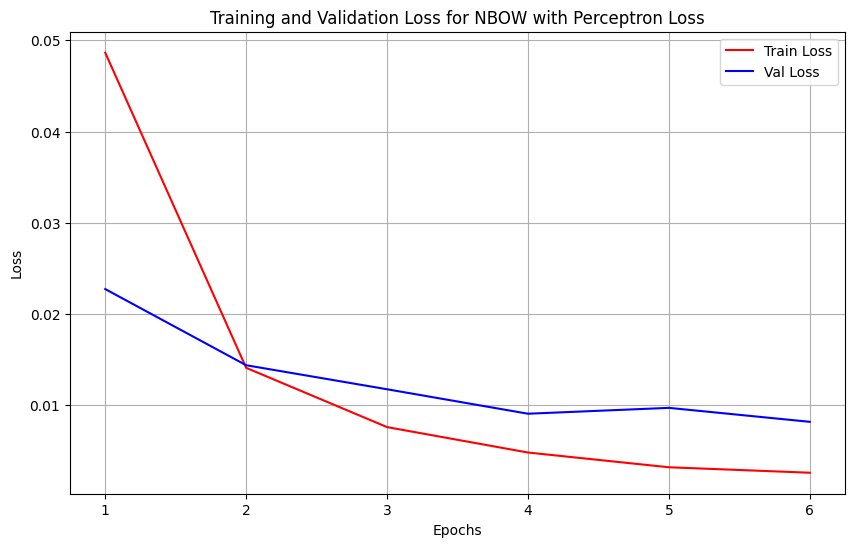

In [80]:
# DO NOT CHANGE THIS CELL
plot_loss(train_loss_over_time_perceptron, val_loss_over_time_perceptron, 'NBOW with Perceptron Loss')

In [81]:
# DO NOT CHANGE THIS CELL
# load best model from checkpoint
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'perceptron', map_location=device)

# evaluate model
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 22.33it/s]

Final Validation Accuracy: 0.7045092838196286
Final Validation F1-Score: 0.7018123417153094


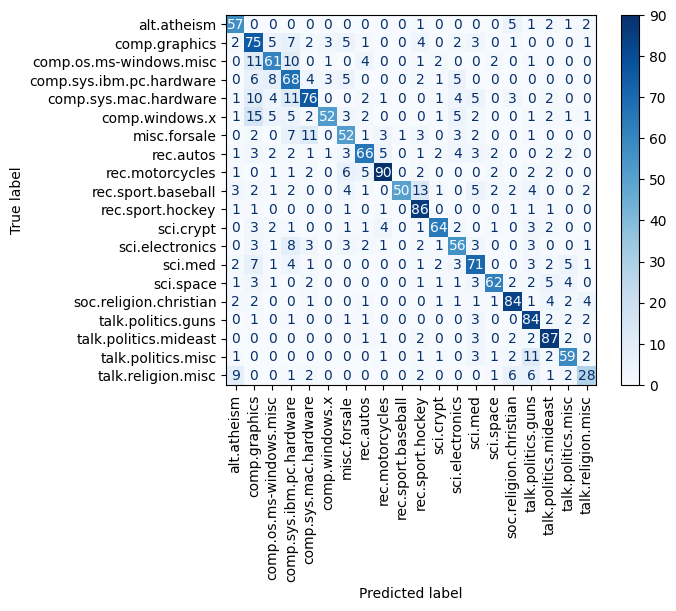

In [82]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 6.3. Hinge Loss (5 points - Programming)

Read through the dataset documentation link provided with this notebook, or feel free to Google and read about 20 Newsgroups dataset, it's quite popular. If you try to understand the labels, they are more similar to some of them than others, semantically. For example, `talk.politics.mideast` is more closer to `talk.politics.misc` than `sci.space`.

Mathematically speaking, it means that misclassification of a label to some classes may be less penalizable than some other classes. This is the perfect scenario of using hinge loss.

The **hinge loss** is another loss function commonly used for classification, especially in **support vector machines (SVMs)**. It is designed to maximize the margin between the decision boundary and the closest data points from each class.

The hinge loss penalizes predictions based on how confident the model is about the correct class relative to other classes. It aims to push the score of the true class far above the scores of all other classes, ensuring that the model not only predicts the correct class but does so confidently.

For each input sample $x_i$, the model computes a score for each class. The hinge loss compares the score for the true class to the scores for all other classes and penalizes the model if the true class score is not sufficiently higher than the scores for the other classes.

Given a set of predictions from the model for a batch of samples, we denote:

- $\mathbf{y} \in \mathbb{R}^{B \times C}$: The matrix of predicted scores, where $B$ is the batch size and $C$ is the number of classes. Each row represents the predicted scores for one sample.
- $\mathbf{y}_{\text{true}} \in \{0, 1, \ldots, C-1\}^{B}$: The ground truth labels, where each entry is an integer representing the correct class label for each sample.

For a given sample \( i \), let:

- $s_j$ be the score for class $j$ (from the predicted score vector).
- $s_{\text{true}}$ be the score for the true class.
- $l(j, true)$ be the cost if a task instance belonging to $true$ has highest score for $j$

The **hinge loss** for a task instance \( x_i \) is defined as:

$$
L_{\text{hinge}}(i) = \max \left( 0, \max_j\left(s_j + l(j, true)\right) - s_{\text{true}}\right)
$$

For batches, we compute the loss for each sample and take the mean over the batch to obtain a scalar value representing the average hinge loss.

HINT: The non-recommended solution is to use one loop. However, it is highly recommended to not do that for efficiency reasons. `torch.gather()` should be helpful.


In [83]:
# export
class HingeLoss(nn.Module):
    def __init__(self, cost_matrix, device):
        super(HingeLoss, self).__init__()
        """
        cost_matrix is a 2D list. Convert it to a tensor on appropriate device.
        """
        # YOUR CODE STARTS HERE
        self.cost_matrix = torch.tensor(cost_matrix, dtype=torch.float32, device=device)
        # YOUR CODE ENDS HERE

    def forward(self, predictions, labels):
        """
        Calculate the hinge loss between predictions and labels, adjusting for cost.

        Args:
            predictions (torch.Tensor): The predictions from the model for a batch of inputs.
                                        Shape should be (batch_size, num_classes).
            labels (torch.Tensor): The ground truth labels for each input in the batch.
                                   Shape should be (batch_size,) with each value between 0 and num_classes-1.

        Returns:
            scalar: The mean hinge loss for the batch, adjusted for the defined cost.
        """
        loss = None
        # YOUR CODE STARTS HERE
        batch_size, num_classes = predictions.shape

        # Extract the true class scores for each sample
        true_scores = predictions[torch.arange(batch_size), labels].unsqueeze(1)  # shape: (B, 1)

        # Get cost for each (true_label, j) pair
        cost_values = self.cost_matrix[labels]  # shape: (B, C)

        # Compute per-class hinge margin: s_j + cost(j, true) - s_true
        margins = predictions + cost_values - true_scores

        # For each sample, find the maximum margin across all classes
        max_margin, _ = torch.max(margins, dim=1)

        # Apply hinge: max(0, margin)
        hinge_loss = torch.clamp(max_margin, min=0)

        # Average across batch
        loss = hinge_loss.mean()
        # YOUR CODE ENDS HERE
        return loss

In [85]:
# DO NOT CHANGE THIS CELL
def test_correct_classification(hinge_loss):
    """
    Test case where the true class has the highest score.
    The loss should be 0.
    """
    rtol = 0.0001
    predictions = torch.tensor([[3.0, 2.0, 1.0],
                                [1.0, 4.0, 2.0]])
    labels = torch.tensor([0, 1])
    loss = hinge_loss(predictions, labels).item()
    expected_loss = 0.0
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case 1 passed')
    else:
        print(f"Test case 1 failed, expected value was\n{expected_loss}\nbut you got:\n{loss}")

def test_incorrect_classification(hinge_loss):
    """
    Test case where the true class does not have the highest score.
    The loss should be greater than 0.
    """
    rtol = 0.0001
    predictions = torch.tensor([[1.0, 3.0, 2.0],
                                [1.0, 2.0, 4.0]])
    labels = torch.tensor([0, 1])

    expected_loss = 3.0
    loss = hinge_loss(predictions, labels).item()

    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case 2 passed')
    else:
        print(f"Test case 2 failed, expected value was\n{expected_loss}\nbut you got:\n{loss}")

cost_matrix = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
hinge_loss = HingeLoss(cost_matrix, device='cpu')
test_correct_classification(hinge_loss)
test_incorrect_classification(hinge_loss)

Test case 1 passed
Test case 2 passed


### 6.4. NBOW Training using Hinge Loss [3 points - Programming]

First, define a cost matrix. Take inspiration from the confusion matrix of `PerceptronLoss` results, `id2label` map and your knowledge of what dataset labels are. This will help is constructing a good cost matrix.

Credits will be awarded on the following cutoffs on Gradescope split -
- 0 points for accuracy <= 84%,
- 1 point for accuracy > 84% but <= 88%,
- 2 points for accuracy > 88%

In [86]:
# export
def get_cost_matrix(num_classes=20):
    """
    Generates a cost matrix for a specified number of classes using Python lists.

    Args:
        num_classes (int): The number of classes for which the cost matrix is to be created.

    Returns:
        list of lists: A 2D list where element (i, j) is the absolute difference between i and j,
                       set to zero if i equals j.
    """
    cost_matrix = None
    # YOUR CODE STARTS HERE
    cost_matrix = [[abs(i - j) if i != j else 0 for j in range(num_classes)]
                   for i in range(num_classes)]
    # YOUR CODE ENDS HERE
    return cost_matrix

In [87]:
# DO NOT CHANGE THIS CELL
def test_cost(matrix):
    n = len(matrix)

    # Check if the matrix is square
    for row in matrix:
        if len(row) != n:
            print('Incorrect cost matrix: Not a square matrix.')

    # Check for symmetry and zero diagonal elements
    for i in range(n):
        if matrix[i][i] != 0:
            print('Incorrect cost matrix: Diagonal elements are not zero.')

        for j in range(i + 1, n):
            if matrix[i][j] != matrix[j][i]:
                print('Incorrect cost matrix: Not a symmetric matrix.')

    print('Valid cost matrix')

cost_matrix = get_cost_matrix()
test_cost(cost_matrix)

Valid cost matrix


In [88]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
cost_matrix = get_cost_matrix()
criterion = HingeLoss(cost_matrix, device=device)
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_hinge = []
val_loss_over_time_hinge = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_hinge.append(train_loss)
    val_loss_over_time_hinge.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

save_checkpoint(nbow_model, 'nbow', loss_fn='hinge')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 28.58it/s]


Epoch 1 -- Train_Loss: 11.035942578719833 -- Val_Loss: 9.753194300333659 -- Val_Accuracy: 0.04880636604774536 -- Val_F1: 0.0046582278481012655


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 23.83it/s]


Epoch 2 -- Train_Loss: 9.321664434368328 -- Val_Loss: 9.070507431030274 -- Val_Accuracy: 0.05994694960212202 -- Val_F1: 0.015813756329501563


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 28.91it/s]


Epoch 3 -- Train_Loss: 8.344733909025031 -- Val_Loss: 7.8190583229064945 -- Val_Accuracy: 0.1506631299734748 -- Val_F1: 0.07975382047405011


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 19.55it/s]


Epoch 4 -- Train_Loss: 7.0777757086996305 -- Val_Loss: 6.55215539932251 -- Val_Accuracy: 0.22652519893899203 -- Val_F1: 0.15022304502957357


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 29.75it/s]


Epoch 5 -- Train_Loss: 5.750341956898318 -- Val_Loss: 5.315410232543945 -- Val_Accuracy: 0.38249336870026523 -- Val_F1: 0.28267275605784564


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 23.57it/s]


Epoch 6 -- Train_Loss: 4.567020610227424 -- Val_Loss: 4.393522342046102 -- Val_Accuracy: 0.5188328912466843 -- Val_F1: 0.42542279294848395
Checkpoint saved to /content/drive/MyDrive/HW2/model_weights/checkpoint_nbow_hinge.pt


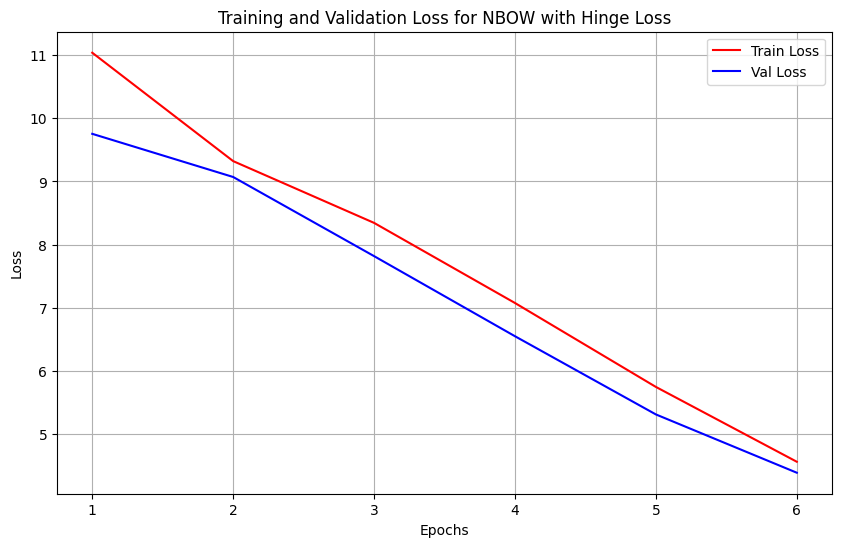

In [89]:
# DO NOT CHANGE THIS CELL
plot_loss(train_loss_over_time_hinge, val_loss_over_time_hinge, 'NBOW with Hinge Loss')

In [90]:
# DO NOT CHANGE THIS CELL
# load best model from checkpoint
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'hinge', map_location=device)

# evaluate model
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 29.42it/s]


Final Validation Accuracy: 0.5188328912466843
Final Validation F1-Score: 0.42542279294848395


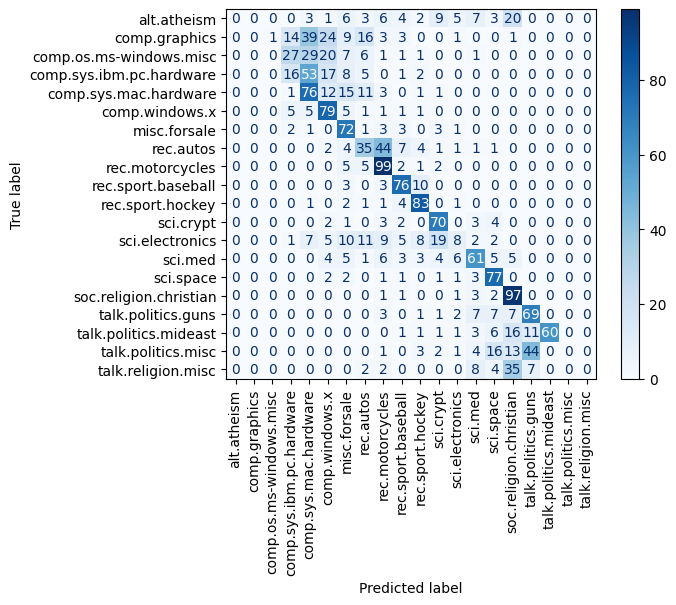

In [91]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 7. Analysis [21 Points - Non-programming]

These are some analytical questions based on implementations done above.

Note for all analysis questions: Be sure to isolate all your code/textual answers into separate cells without modifying code in other exported functions as they are still used for grade scope test cases. Feel free to add as many code and markdown cells as you see fit to explain your answer.

Code should be in code cells and write-ups should strictly be in markdown cells. Please note, these will be manually evaluated due to large variation in possible answers. So, visibility of code, explanation and output in the PDF is the key.

### 7.1. Analyzing NBOW Weights [7 points - Non-programming]

Load your trained `NBOW` model here, and let $w$ be the weight of your linear layer of the model. It will be of the shape of `(num_classes, embedding_dim)`.

For this tensor, compute $ww^T$ and show it as a heatmap (a sample code to generate heatmap is shown below).

Explain the generated output. What does it resemble? What do high and low values of coefficients at position i, j indicate? With the help of the dataset documentation and `id2label` map displayed earlier in this notebook, can you reason why certain values are high and why certain values are low? What does it tell you about the class labels?

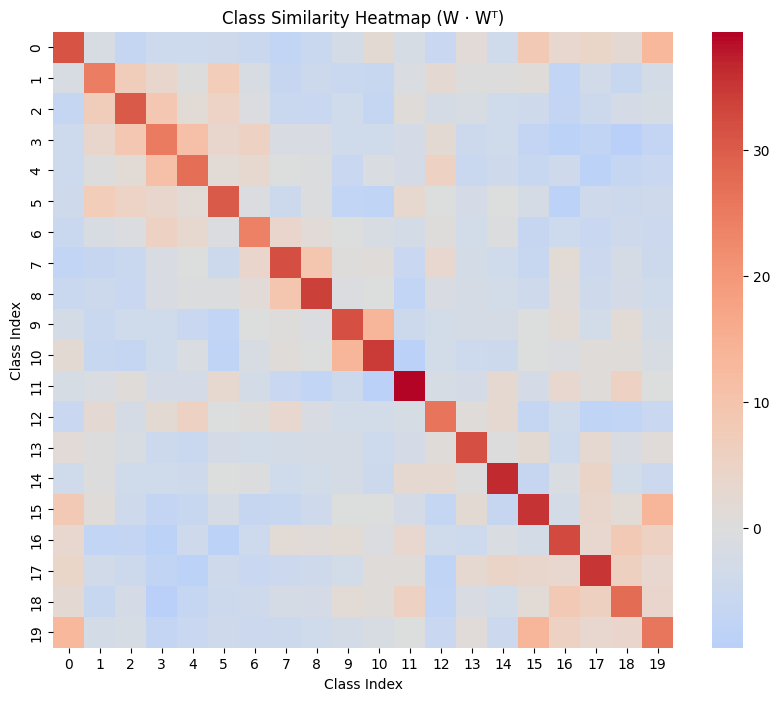

In [107]:
# Load trained NBOW model
nbow_model = get_nbow_model(len(train_vocab.keys()), embedding_dim)
load_checkpoint(nbow_model, 'nbow', map_location=device)

# Extract classifier weight matrix (num_classes x embedding_dim)
W = nbow_model.fc.weight.detach().cpu().numpy()

# Compute similarity matrix
WWT = np.dot(W, W.T)

# Plot as heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(WWT, cmap='coolwarm', center=0)
plt.title("Class Similarity Heatmap (W · Wᵀ)")
plt.xlabel("Class Index")
plt.ylabel("Class Index")
plt.show()

The $ww^T$ heatmap resembles a semantic similarity map of the 20 Newsgroups topics.
High coefficients reflect related subject areas (shared vocabulary),
while low or negative coefficients mark distinct, unrelated classes.
This demonstrates that the NBOW model learned meaningful inter-class structure beyond simple label boundaries.

### 7.2. Word Embeddings and the Attention Vector [7 points - Non Programming]

From your trained `SimpleAttentionNBOW` model, analyze all word embeddings and the attention vector `u`. Look at the words which have the highest cosine similarity with `u`. Print the 15 words with highest cosine similarity to `u` and the 15 with lowest cosine similarity to `u`. Why do you think those words have high/low cosine similarity to `u` (and therefore high/low attention weights on average)? Form a hypothesis to explain what you see.

In [109]:
import torch
import torch.nn.functional as F

# 1) Load your trained SimpleAttentionNBOW
attn_model = get_simple_attention_model(len(train_vocab.keys()), embedding_dim)
load_checkpoint(attn_model, 'simple_attention', map_location=device)

# 2) Extract the attention vector u robustly (works regardless of its attribute name)
u = None
for name, p in attn_model.named_parameters():
    # skip embedding weights and classifier weights/biases
    if 'embedding' in name or 'fc' in name:
        continue
    # the attention vector is the only 1-D parameter of size embedding_dim
    if p.ndim == 1 and p.numel() == attn_model.embedding.embedding_dim:
        u = p.detach().cpu()
        print(f"Using attention parameter: {name}")
        break

if u is None:
    # fall back: show what parameters exist so you can pick the right one
    print("Could not auto-detect attention vector. Available params:")
    print([n for n, _ in attn_model.named_parameters()])
    raise RuntimeError("Attention vector not found—see the printed parameter names.")

# 3) Get the embedding matrix
E = attn_model.embedding.weight.detach().cpu()

# 4) Cosine similarity between every word embedding and u
E_n = F.normalize(E, dim=1)          # (V, D)
u_n = F.normalize(u, dim=0)          # (D,)
cos_sim = (E_n @ u_n)                # (V,)

# 5) Map ids -> tokens
id2word = {idx: tok for tok, idx in train_vocab.items()}

# 6) Exclude special tokens if present
special_ids = set()
if 'UNK' in train_vocab: special_ids.add(train_vocab['UNK'])
if '' in train_vocab:    special_ids.add(train_vocab[''])  # padding token in this notebook
mask = torch.ones_like(cos_sim, dtype=torch.bool)
for sid in special_ids:
    if 0 <= sid < mask.numel():
        mask[sid] = False

# 7) Top 15 and Bottom 15
k = 15
valid_scores = cos_sim[mask]
valid_indices = torch.arange(cos_sim.numel())[mask]

top_vals, top_pos = torch.topk(valid_scores, k, largest=True)
bot_vals, bot_pos = torch.topk(valid_scores, k, largest=False)

top_ids = valid_indices[top_pos].tolist()
bot_ids = valid_indices[bot_pos].tolist()

print("\nTop 15 words by cosine(u, emb):")
for wid, val in zip(top_ids, top_vals.tolist()):
    print(f"{id2word.get(int(wid), str(wid))}\t{val:.4f}")

print("\nBottom 15 words by cosine(u, emb):")
for wid, val in zip(bot_ids, bot_vals.tolist()):
    print(f"{id2word.get(int(wid), str(wid))}\t{val:.4f}")

Using attention parameter: att_vector

Top 15 words by cosine(u, emb):
hockey	0.4077
cars	0.3717
sale	0.3574
encryption	0.3537
apple	0.3461
car	0.3404
sw.stratus.com	0.3395
lc	0.3367
dod	0.3337
images	0.3321
expo.lcs.mit.edu	0.3264
jmd	0.3182
space	0.3169
israeli	0.3160
nhl	0.3147

Bottom 15 words by cosine(u, emb):
\	-0.7884
:	-0.6136
,	-0.5116
from	-0.4820
subject	-0.4675
.	-0.4610
>	-0.4554
the	-0.4415
)	-0.4256
@	-0.3952
to	-0.3917
a	-0.3899
(	-0.3834
and	-0.3659
in	-0.3582


The attention vector (u) represents the model’s notion of what makes a word informative for classification. By comparing each word’s embedding to u via cosine similarity, we can see which words the model attends to most strongly and which it largely ignores. These words are content heavy nouns tied to specific discussion topics, sports, technology, products, and security, which tend to be strong predictors of document category. The attention vector assigns them large positive similarity, meaning the model emphasizes such tokens when forming the sentence representation. These are mostly punctuation, stopwords, or structural tokens that occur frequently across all classes and carry little semantic information. Their negative similarity indicates the model effectively down weights them assigning low attention weights during aggregation. The attention mechanism learned to focus on semantically rich content words that distinguish document topics while suppressing common or formatting tokens. This aligns with the goal of attention: to highlight words that are contextually informative for classification. The clear separation between nouns like hockey, car, apple and functional words like the, and, in shows that the attention vector is capturing domain level relevance rather than raw frequency.

### 7.3. Analysis of Cost Matrix in Hinge Loss [7 points - Non-programming]

Display the confusion matrices of prediction of `NBOW` with `PerceptronLoss` and `HingeLoss`. Also print the cost matrix you used for the Hinge Loss.

Using this confusion matrix, `id2label` mapping provided earlier, your knowledge about what labels in the dataset represent, explain the motivation behind creating the provided cost matrix. Why were some of the coefficients higher than others (if)?

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 28.48it/s]


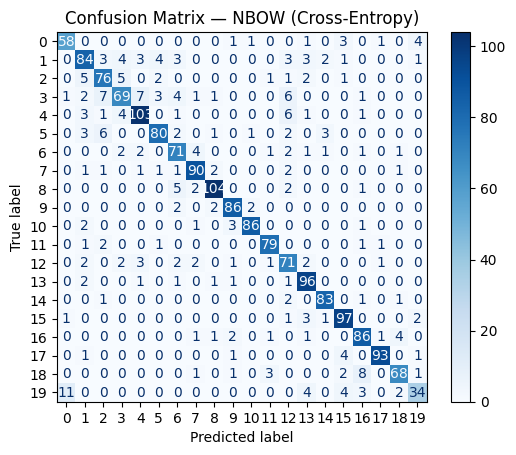

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 27.57it/s]


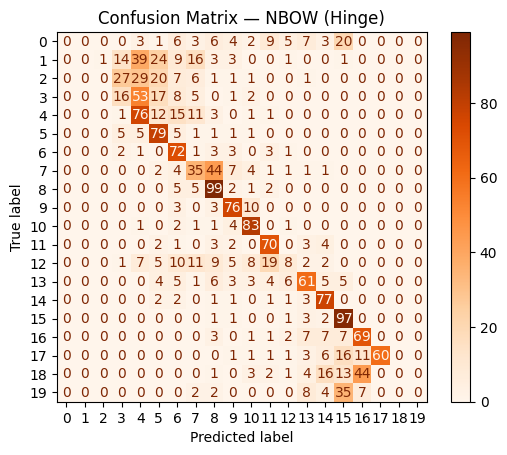

In [113]:
# NBOW (Cross-Entropy) version
nbow_ce = get_nbow_model(len(train_vocab.keys()), embedding_dim)
load_checkpoint(nbow_ce, 'nbow', loss_fn='ce', map_location=device)

true_ce, pred_ce, _ = val_loop(nbow_ce, criterion, val_iterator)
ConfusionMatrixDisplay(confusion_matrix(true_ce, pred_ce)).plot(
    cmap='Blues', values_format='d'
)
plt.title("Confusion Matrix — NBOW (Cross-Entropy)")
plt.show()

# NBOW (Hinge) version
nbow_hinge = get_nbow_model(len(train_vocab.keys()), embedding_dim)
load_checkpoint(nbow_hinge, 'nbow', loss_fn='hinge', map_location=device)

true_h, pred_h, _ = val_loop(nbow_hinge, criterion, val_iterator)
ConfusionMatrixDisplay(confusion_matrix(true_h, pred_h)).plot(
    cmap='Oranges', values_format='d'
)
plt.title("Confusion Matrix — NBOW (Hinge)")
plt.show()

The Hinge Loss NBOW shows slightly broader confusion patterns compared to Cross-Entropy because hinge loss optimizes margin boundaries rather than probability distributions. The cost matrix used for hinge penalizes certain misclassifications more severely, particularly those between semantically unrelated topics, to emphasize separability across distant classes. This explains why some coefficients are higher: they correspond to label pairs where confusion would be conceptually more damaging, for example “politics” vs “sports”. Cross-Entropy treats all errors equally, while Hinge Loss enforces margin-based prioritization guided by that cost structure.

## 8. Improving Attention Models [BONUS] [10 points - Non-programming]

Hopefully you’ve developed some intuition for using attention for this task. Now, come up with your own ways of modifying the attention function and experiment with them. Can you find an idea that outperforms your models from Sections 5?
Some potential ideas are below:
- Use transformation matrices to distinguish key, query, and value representations
- Add additional layers of self-attention before the attention-weighted sum of embeddings
- Compute features in the attention function based on characteristics of where the word is in the sentence, e.g., features of the sentence length, nearby words, the presence of negation words before or after the word, information from a part-of-speech tagger or syntactic parse of the sentence, etc.
- Use multiple word embedding spaces for when words are used as keys, queries, and values, or some subset of the three.

Describe your best new attention function formally below, along with the execution code and experimental results. Add as many code and markdown cells as you want, and submit the complete working with explanation.

## 9. Submitting Your Assignment

This is the end. Congratulations!  

Now, follow the steps below to submit your homework on Gradescope.

### 9.1. Programming

The programming will be evaluated through an autograder. To create the file to submit for autograder, follow the steps below -
1. Open a terminal from the root directory of the project
2. Run the collect_submission.py file
3. Agree to the Late Policy and Honor Pledge
4. After the file is executed, your root project will have a submission directory.
5. Submit all the contents of this file to GradeScope

### 9.2. Non-Programming

The analysis parts will be evaluated manually. For this, export the notebook to a PDF file, and submit it on GradeScope. Please ensure no written code or output is clipped when you create your PDF. One reliable way to do it is first download it as HTML through Jupyter Notebook and then print it to get PDF.